# Ejercicio 1: Análisis Exploratorio de Datos

In [40]:
#%pip install pandas
#%pip install numpy
#%pip install matplotlib
#%pip install statsmodels
#%pip install tensorflow
#%pip install keras
#%pip install scikit-learn
#%pip install distutils
#%pip install openpyxl


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras

%matplotlib inline

In [42]:
precios_2021 = pd.read_excel('PRECIOS 2021.xlsx', engine='openpyxl')
precios_2022 = pd.read_excel('PRECIOS 2022.xlsx', engine='openpyxl')
precios_2023 = pd.read_excel('PRECIOS 2023.xlsx', engine='openpyxl')
precios_2024 = pd.read_excel('PRECIOS 2024.xlsx', engine='openpyxl')

consumo = pd.read_excel('CONSUMO.xlsx', engine='openpyxl')
importacion = pd.read_excel('IMPORTACION.xlsx', engine='openpyxl')

In [43]:
# Unificar datos de precios
precios = pd.concat([precios_2021, precios_2022, precios_2023, precios_2024], ignore_index=True)

# Convertir columnas de fecha a datetime
consumo['Fecha'] = pd.to_datetime(consumo['Fecha'], format='%b/%Y')
importacion['Fecha'] = pd.to_datetime(importacion['Fecha'], format='%b/%Y')
precios['FECHA'] = pd.to_datetime(precios['FECHA'], format='%d/%b/%Y')

In [44]:
consumo_seleccionado = consumo[['Fecha', 'Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petróleo']]
importacion_seleccionado = importacion[['Fecha', 'Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Gas licuado de petróleo']]
precios_seleccionado = precios[['FECHA', 'Superior', 'Regular', 'Diesel', 'Glp Cilindro 25Lbs.']]


In [45]:
consumo_seleccionado.set_index('Fecha', inplace=True)
importacion_seleccionado.set_index('Fecha', inplace=True)
precios_seleccionado.set_index('FECHA', inplace=True)

In [46]:
# Selección de series
serie_gasolina_super = consumo_seleccionado['Gasolina superior']
serie_gasolina_regular = consumo_seleccionado['Gasolina regular']
serie_diesel = consumo_seleccionado['Diesel bajo azufre']
serie_gas_lp = consumo_seleccionado['Gas licuado de petróleo']

# Series de importación
serie_gasolina_super_import = importacion_seleccionado['Gasolina superior']
serie_gasolina_regular_import = importacion_seleccionado['Gasolina regular']
serie_diesel_import = importacion_seleccionado['Diesel bajo azufre']
serie_gas_lp_import = importacion_seleccionado['Gas licuado de petróleo']

# Series de precios
serie_gasolina_super_precios = precios_seleccionado['Superior']
serie_gasolina_regular_precios = precios_seleccionado['Regular']
serie_diesel_precios = precios_seleccionado['Diesel']
serie_gas_lp_precios = precios_seleccionado['Glp Cilindro 25Lbs.']


In [47]:
serie_gasolina_super_ = consumo_seleccionado['Gasolina superior']
serie_gasolina_regular_ = consumo_seleccionado['Gasolina regular']
serie_diesel_ = consumo_seleccionado['Diesel bajo azufre']
serie_gas_lp_ = consumo_seleccionado['Gas licuado de petróleo']

# Series de importación
serie_gasolina_super_import_ = importacion_seleccionado['Gasolina superior']
serie_gasolina_regular_import_ = importacion_seleccionado['Gasolina regular']
serie_diesel_import_ = importacion_seleccionado['Diesel bajo azufre']
serie_gas_lp_import_ = importacion_seleccionado['Gas licuado de petróleo']

# Series de precios
serie_gasolina_super_precios_ = precios_seleccionado['Superior']
serie_gasolina_regular_precios_ = precios_seleccionado['Regular']
serie_diesel_precios_ = precios_seleccionado['Diesel']
serie_gas_lp_precios_ = precios_seleccionado['Glp Cilindro 25Lbs.']

## Creación de los modelos. 

In [48]:
# Quitar los datos de 2024 para abajo de las series de tiempo
# Los test seran de 2024 en adelante
serie_gasolina_super_test = serie_gasolina_super['2021-01-01':]
serie_gasolina_regular_test = serie_gasolina_regular['2021-01-01':]
serie_diesel_test = serie_diesel['2021-01-01':]
serie_gas_lp_test = serie_gas_lp['2021-01-01':]

# Eliminar NaNs
serie_gasolina_super_test = serie_gasolina_super_test.dropna()
serie_gasolina_regular_test = serie_gasolina_regular_test.dropna()
serie_diesel_test = serie_diesel_test.dropna()
serie_gas_lp_test = serie_gas_lp_test.dropna()

# Obtener los datos de validation
serie_gasolina_super_validation = serie_gasolina_super['2020-01-01':'2020-12-31']
serie_gasolina_regular_validation = serie_gasolina_regular['2020-01-01':'2020-12-31']
serie_diesel_validation = serie_diesel['2020-01-01':'2020-12-31']
serie_gas_lp_validation = serie_gas_lp['2020-01-01':'2020-12-31']


# Remplazamos las series por las que tienen los datos de 2024 para abajo
serie_gasolina_super = serie_gasolina_super[:'2019-12-31']
serie_gasolina_regular = serie_gasolina_regular[:'2019-12-31']
serie_diesel = serie_diesel[:'2019-12-31']
serie_gas_lp = serie_gas_lp[:'2019-12-31']





In [49]:
# Quitar los datos de 2024 para abajo de las series de importación
# Los test seran de 2024 en adelante
serie_gasolina_super_import_test = serie_gasolina_super_import['2021-01-01':]
serie_gasolina_regular_import_test = serie_gasolina_regular_import['2021-01-01':]
serie_diesel_import_test = serie_diesel_import['2021-01-01':]
serie_gas_lp_import_test = serie_gas_lp_import['2021-01-01':]

# Eliminar NaNs
serie_gasolina_super_import_test = serie_gasolina_super_import_test.dropna()
serie_gasolina_regular_import_test = serie_gasolina_regular_import_test.dropna()
serie_diesel_import_test = serie_diesel_import_test.dropna()
serie_gas_lp_import_test = serie_gas_lp_import_test.dropna()

# Obtener los datos de validation
serie_gasolina_super_import_validation = serie_gasolina_super_import['2020-01-01':'2020-12-31']
serie_gasolina_regular_import_validation = serie_gasolina_regular_import['2020-01-01':'2020-12-31']
serie_diesel_import_validation = serie_diesel_import['2020-01-01':'2020-12-31']
serie_gas_lp_import_validation = serie_gas_lp_import['2020-01-01':'2020-12-31']


# Remplazamos las series por las que tienen los datos de 2024 para abajo
serie_gasolina_super_import = serie_gasolina_super_import[:'2019-12-31']
serie_gasolina_regular_import = serie_gasolina_regular_import[:'2019-12-31']
serie_diesel_import = serie_diesel_import[:'2019-12-31']
serie_gas_lp_import = serie_gas_lp_import[:'2019-12-31']

In [50]:
# Quitar los datos de 2024 para abajo de las series de precios
# Los test seran de 2024 en adelante
serie_gasolina_super_precios_test = serie_gasolina_super_precios['2024-01-01':]
serie_gasolina_regular_precios_test = serie_gasolina_regular_precios['2024-01-01':]
serie_diesel_precios_test = serie_diesel_precios['2024-01-01':]
serie_gas_lp_precios_test = serie_gas_lp_precios['2024-01-01':]

# Eliminar NaNs
serie_gasolina_super_precios_test = serie_gasolina_super_precios_test.dropna()
serie_gasolina_regular_precios_test = serie_gasolina_regular_precios_test.dropna()
serie_diesel_precios_test = serie_diesel_precios_test.dropna()
serie_gas_lp_precios_test = serie_gas_lp_precios_test.dropna()

# Obtener los datos de validation
serie_gasolina_super_precios_validation = serie_gasolina_super_precios['2023-01-01':'2023-12-31']
serie_gasolina_regular_precios_validation = serie_gasolina_regular_precios['2023-01-01':'2023-12-31']
serie_diesel_precios_validation = serie_diesel_precios['2023-01-01':'2023-12-31']
serie_gas_lp_precios_validation = serie_gas_lp_precios['2023-01-01':'2023-12-31']

# Remplazamos las series por las que tienen los datos de 2024 para abajo
serie_gasolina_super_precios = serie_gasolina_super_precios[:'2022-12-31']
serie_gasolina_regular_precios = serie_gasolina_regular_precios[:'2022-12-31']
serie_diesel_precios = serie_diesel_precios[:'2022-12-31']
serie_gas_lp_precios = serie_gas_lp_precios[:'2022-12-31']

### Se normalizan las series para que las redes neuronales trabajen mejor con ellas. 

In [51]:
# Normalizamos las series
scaler = StandardScaler()
scaler.fit(serie_gasolina_super.values.reshape(-1, 1))
index_precios_super = serie_gasolina_super.index
serie_gasolina_super_precios = scaler.transform(serie_gasolina_super_precios.values.reshape(-1, 1))
index_precios_regular = serie_gasolina_regular.index
serie_gasolina_regular_precios = scaler.transform(serie_gasolina_regular_precios.values.reshape(-1, 1))
index_precios_diesel = serie_diesel.index
serie_diesel_precios = scaler.transform(serie_diesel_precios.values.reshape(-1, 1))
index_precios_gas_lp = serie_gas_lp.index
serie_gas_lp_precios = scaler.transform(serie_gas_lp_precios.values.reshape(-1, 1))


# Normalizamos las series de importación
scaler_import = StandardScaler()
scaler_import.fit(serie_gasolina_super_import.values.reshape(-1, 1))
serie_gasolina_super_import = scaler_import.transform(serie_gasolina_super_import.values.reshape(-1, 1))
serie_gasolina_regular_import = scaler_import.transform(serie_gasolina_regular_import.values.reshape(-1, 1))
serie_diesel_import = scaler_import.transform(serie_diesel_import.values.reshape(-1, 1))
serie_gas_lp_import = scaler_import.transform(serie_gas_lp_import.values.reshape(-1, 1))

# Normalizamos las series de consumo
scaler_consumo = StandardScaler()
scaler_consumo.fit(serie_gasolina_super.values.reshape(-1, 1))
serie_gasolina_super = scaler_consumo.transform(serie_gasolina_super.values.reshape(-1, 1))
serie_gasolina_regular = scaler_consumo.transform(serie_gasolina_regular.values.reshape(-1, 1))
serie_diesel = scaler_consumo.transform(serie_diesel.values.reshape(-1, 1))
serie_gas_lp = scaler_consumo.transform(serie_gas_lp.values.reshape(-1, 1))

In [52]:
# Normalizamos las series de test
scaler_test = StandardScaler()
scaler_test.fit(serie_gasolina_super_test.values.reshape(-1, 1))
index_test_super = serie_gasolina_super_test.index
serie_gasolina_super_test = scaler_test.transform(serie_gasolina_super_test.values.reshape(-1, 1))
index_test_regular = serie_gasolina_regular_test.index
serie_gasolina_regular_test = scaler_test.transform(serie_gasolina_regular_test.values.reshape(-1, 1))
index_test_diesel = serie_diesel_test.index
serie_diesel_test = scaler_test.transform(serie_diesel_test.values.reshape(-1, 1))
index_test_gas_lp = serie_gas_lp_test.index
serie_gas_lp_test = scaler_test.transform(serie_gas_lp_test.values.reshape(-1, 1))

# Normalizamos las series de importación de test
scaler_import_test = StandardScaler()
scaler_import_test.fit(serie_gasolina_super_import_test.values.reshape(-1, 1))
index_test_import_super = serie_gasolina_super_import_test.index
serie_gasolina_super_import_test = scaler_import_test.transform(serie_gasolina_super_import_test.values.reshape(-1, 1))
index_test_import_regular = serie_gasolina_regular_import_test.index
serie_gasolina_regular_import_test = scaler_import_test.transform(serie_gasolina_regular_import_test.values.reshape(-1, 1))
index_test_import_diesel = serie_diesel_import_test.index
serie_diesel_import_test = scaler_import_test.transform(serie_diesel_import_test.values.reshape(-1, 1))
index_test_import_gas_lp = serie_gas_lp_import_test.index
serie_gas_lp_import_test = scaler_import_test.transform(serie_gas_lp_import_test.values.reshape(-1, 1))

# Normalizamos las series de precios de test
scaler_precios_test = StandardScaler()
scaler_precios_test.fit(serie_gasolina_super_precios_test.values.reshape(-1, 1))
index_test_precios_super = serie_gasolina_super_precios_test.index
serie_gasolina_super_precios_test = scaler_precios_test.transform(serie_gasolina_super_precios_test.values.reshape(-1, 1))
index_test_precios_regular = serie_gasolina_regular_precios_test.index
serie_gasolina_regular_precios_test = scaler_precios_test.transform(serie_gasolina_regular_precios_test.values.reshape(-1, 1))
index_test_precios_diesel = serie_diesel_precios_test.index
serie_diesel_precios_test = scaler_precios_test.transform(serie_diesel_precios_test.values.reshape(-1, 1))
index_test_precios_gas_lp = serie_gas_lp_precios_test.index
serie_gas_lp_precios_test = scaler_precios_test.transform(serie_gas_lp_precios_test.values.reshape(-1, 1))


In [53]:
# Normalizamos las series de validation
scaler_validation = StandardScaler()
scaler_validation.fit(serie_gasolina_super_validation.values.reshape(-1, 1))
index_validation_super = serie_gasolina_super_validation.index
serie_gasolina_super_validation = scaler_validation.transform(serie_gasolina_super_validation.values.reshape(-1, 1))
index_validation_regular = serie_gasolina_regular_validation.index
serie_gasolina_regular_validation = scaler_validation.transform(serie_gasolina_regular_validation.values.reshape(-1, 1))
index_validation_diesel = serie_diesel_validation.index
serie_diesel_validation = scaler_validation.transform(serie_diesel_validation.values.reshape(-1, 1))
index_validation_gas_lp = serie_gas_lp_validation.index
serie_gas_lp_validation = scaler_validation.transform(serie_gas_lp_validation.values.reshape(-1, 1))


# Normalizamos las series de importación de validation
scaler_import_validation = StandardScaler()
scaler_import_validation.fit(serie_gasolina_super_import_validation.values.reshape(-1, 1))
index_import_validation_super = serie_gasolina_super_import_validation.index
serie_gasolina_super_import_validation = scaler_import_validation.transform(serie_gasolina_super_import_validation.values.reshape(-1, 1))
index_import_validation_regular = serie_gasolina_regular_import_validation.index
serie_gasolina_regular_import_validation = scaler_import_validation.transform(serie_gasolina_regular_import_validation.values.reshape(-1, 1))
index_import_validation_diesel = serie_diesel_import_validation.index
serie_diesel_import_validation = scaler_import_validation.transform(serie_diesel_import_validation.values.reshape(-1, 1))
index_import_validation_gas_lp = serie_gas_lp_import_validation.index
serie_gas_lp_import_validation = scaler_import_validation.transform(serie_gas_lp_import_validation.values.reshape(-1, 1))


# Normalizamos las series de precios de validation
scaler_precios_validation = StandardScaler()
scaler_precios_validation.fit(serie_gasolina_super_precios_validation.values.reshape(-1, 1))
index_precios_validation_super = serie_gasolina_super_precios_validation.index
serie_gasolina_super_precios_validation = scaler_precios_validation.transform(serie_gasolina_super_precios_validation.values.reshape(-1, 1))
index_precios_validation_regular = serie_gasolina_regular_precios_validation.index
serie_gasolina_regular_precios_validation = scaler_precios_validation.transform(serie_gasolina_regular_precios_validation.values.reshape(-1, 1))
index_precios_validation_diesel = serie_diesel_precios_validation.index
serie_diesel_precios_validation = scaler_precios_validation.transform(serie_diesel_precios_validation.values.reshape(-1, 1))
index_precios_validation_gas_lp = serie_gas_lp_precios_validation.index
serie_gas_lp_precios_validation = scaler_precios_validation.transform(serie_gas_lp_precios_validation.values.reshape(-1, 1))


Para que pueda usarse el argoritmo LSTM es necesario transformar la serie en una supervisada, de manera que las observaciones anteriores sean capaces de estimar la siguiente. En este caso vamos a usar el mes anterior para predecir el siguiente por lo que vamos a transformar el arreglo de numpy en una matriz de dos dimensiones en la que la dimensión 1 sea el instante t-1 y la dimensión 2 sea el instante t

In [54]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)



In [55]:
# Supervisar series de consumo
data_consumo = {}
# Gasolina Superior
x_train_gasolina_super_train, y_train_gasolina_super_train = supervisada(serie_gasolina_super,1)
x_train_gasolina_super_test, y_train_gasolina_super_test = supervisada(serie_gasolina_super_test,1)
x_train_gasolina_super_validation, y_train_gasolina_super_validation = supervisada(serie_gasolina_super_validation,1)
data_consumo['gasolina_super'] = {
    'train': (x_train_gasolina_super_train, y_train_gasolina_super_train),
    'test': (x_train_gasolina_super_test, y_train_gasolina_super_test),
    'validation': (x_train_gasolina_super_validation, y_train_gasolina_super_validation)
}

# Gasolina Regular
x_train_gasolina_regular_train, y_train_gasolina_regular_train = supervisada(serie_gasolina_regular,1)
x_train_gasolina_regular_test, y_train_gasolina_regular_test = supervisada(serie_gasolina_regular_test,1)
x_train_gasolina_regular_validation, y_train_gasolina_regular_validation = supervisada(serie_gasolina_regular_validation,1)
data_consumo['gasolina_regular'] = {
    'train': (x_train_gasolina_regular_train, y_train_gasolina_regular_train),
    'test': (x_train_gasolina_regular_test, y_train_gasolina_regular_test),
    'validation': (x_train_gasolina_regular_validation, y_train_gasolina_regular_validation)
}

# Diesel
x_train_diesel_train, y_train_diesel_train = supervisada(serie_diesel,1)
x_train_diesel_test, y_train_diesel_test = supervisada(serie_diesel_test,1)
x_train_diesel_validation, y_train_diesel_validation = supervisada(serie_diesel_validation,1)
data_consumo['diesel'] = {
    'train': (x_train_diesel_train, y_train_diesel_train),
    'test': (x_train_diesel_test, y_train_diesel_test),
    'validation': (x_train_diesel_validation, y_train_diesel_validation)
}

# Gas LP
x_train_gas_lp_train, y_train_gas_lp_train = supervisada(serie_gas_lp,1)
x_train_gas_lp_test, y_train_gas_lp_test = supervisada(serie_gas_lp_test,1)
x_train_gas_lp_validation, y_train_gas_lp_validation = supervisada(serie_gas_lp_validation,1)
data_consumo['gas_lp'] = {
    'train': (x_train_gas_lp_train, y_train_gas_lp_train),
    'test': (x_train_gas_lp_test, y_train_gas_lp_test),
    'validation': (x_train_gas_lp_validation, y_train_gas_lp_validation)
}


In [56]:
# Supervisar series de importación
data_importacion = {}
# Gasolina Superior
x_train_gasolina_super_import_train, y_train_gasolina_super_import_train = supervisada(serie_gasolina_super_import,1)
x_train_gasolina_super_import_test, y_train_gasolina_super_import_test = supervisada(serie_gasolina_super_import_test,1)
x_train_gasolina_super_import_validation, y_train_gasolina_super_import_validation = supervisada(serie_gasolina_super_import_validation,1)
data_importacion['gasolina_super'] = {
    'train': (x_train_gasolina_super_import_train, y_train_gasolina_super_import_train),
    'test': (x_train_gasolina_super_import_test, y_train_gasolina_super_import_test),
    'validation': (x_train_gasolina_super_import_validation, y_train_gasolina_super_import_validation)
}

# Gasolina Regular
x_train_gasolina_regular_import_train, y_train_gasolina_regular_import_train = supervisada(serie_gasolina_regular_import,1)
x_train_gasolina_regular_import_test, y_train_gasolina_regular_import_test = supervisada(serie_gasolina_regular_import_test,1)
x_train_gasolina_regular_import_validation, y_train_gasolina_regular_import_validation = supervisada(serie_gasolina_regular_import_validation,1)
data_importacion['gasolina_regular'] = {
    'train': (x_train_gasolina_regular_import_train, y_train_gasolina_regular_import_train),
    'test': (x_train_gasolina_regular_import_test, y_train_gasolina_regular_import_test),
    'validation': (x_train_gasolina_regular_import_validation, y_train_gasolina_regular_import_validation)
}


# Diesel
x_train_diesel_import_train, y_train_diesel_import_train = supervisada(serie_diesel_import,1)
x_train_diesel_import_test, y_train_diesel_import_test = supervisada(serie_diesel_import_test,1)
x_train_diesel_import_validation, y_train_diesel_import_validation = supervisada(serie_diesel_import_validation,1)
data_importacion['diesel'] = {
    'train': (x_train_diesel_import_train, y_train_diesel_import_train),
    'test': (x_train_diesel_import_test, y_train_diesel_import_test),
    'validation': (x_train_diesel_import_validation, y_train_diesel_import_validation)
}

# Gas LP
x_train_gas_lp_import_train, y_train_gas_lp_import_train = supervisada(serie_gas_lp_import,1)
x_train_gas_lp_import_test, y_train_gas_lp_import_test = supervisada(serie_gas_lp_import_test,1)
x_train_gas_lp_import_validation, y_train_gas_lp_import_validation = supervisada(serie_gas_lp_import_validation,1)
data_importacion['gas_lp'] = {
    'train': (x_train_gas_lp_import_train, y_train_gas_lp_import_train),
    'test': (x_train_gas_lp_import_test, y_train_gas_lp_import_test),
    'validation': (x_train_gas_lp_import_validation, y_train_gas_lp_import_validation)
}

In [57]:
# Supervisar series de precios
data_precios = {}
# Gasolina Superior
x_train_gasolina_super_precios_train, y_train_gasolina_super_precios_train = supervisada(serie_gasolina_super_precios,1)
x_train_gasolina_super_precios_test, y_train_gasolina_super_precios_test = supervisada(serie_gasolina_super_precios_test,1)
x_train_gasolina_super_precios_validation, y_train_gasolina_super_precios_validation = supervisada(serie_gasolina_super_precios_validation,1)
data_precios['gasolina_super'] = {
    'train': (x_train_gasolina_super_precios_train, y_train_gasolina_super_precios_train),
    'test': (x_train_gasolina_super_precios_test, y_train_gasolina_super_precios_test),
    'validation': (x_train_gasolina_super_precios_validation, y_train_gasolina_super_precios_validation)
}


# Gasolina Regular
x_train_gasolina_regular_precios_train, y_train_gasolina_regular_precios_train = supervisada(serie_gasolina_regular_precios,1)
x_train_gasolina_regular_precios_test, y_train_gasolina_regular_precios_test = supervisada(serie_gasolina_regular_precios_test,1)
x_train_gasolina_regular_precios_validation, y_train_gasolina_regular_precios_validation = supervisada(serie_gasolina_regular_precios_validation,1)
data_precios['gasolina_regular'] = {
    'train': (x_train_gasolina_regular_precios_train, y_train_gasolina_regular_precios_train),
    'test': (x_train_gasolina_regular_precios_test, y_train_gasolina_regular_precios_test),
    'validation': (x_train_gasolina_regular_precios_validation, y_train_gasolina_regular_precios_validation)
}


# Diesel
x_train_diesel_precios_train, y_train_diesel_precios_train = supervisada(serie_diesel_precios,1)
x_train_diesel_precios_test, y_train_diesel_precios_test = supervisada(serie_diesel_precios_test,1)
x_train_diesel_precios_validation, y_train_diesel_precios_validation = supervisada(serie_diesel_precios_validation,1)
data_precios['diesel'] = {
    'train': (x_train_diesel_precios_train, y_train_diesel_precios_train),
    'test': (x_train_diesel_precios_test, y_train_diesel_precios_test),
    'validation': (x_train_diesel_precios_validation, y_train_diesel_precios_validation)
}


# Gas LP
x_train_gas_lp_precios_train, y_train_gas_lp_precios_train = supervisada(serie_gas_lp_precios,1)
x_train_gas_lp_precios_test, y_train_gas_lp_precios_test = supervisada(serie_gas_lp_precios_test,1)
x_train_gas_lp_precios_validation, y_train_gas_lp_precios_validation = supervisada(serie_gas_lp_precios_validation,1)
data_precios['gas_lp'] = {
    'train': (x_train_gas_lp_precios_train, y_train_gas_lp_precios_train),
    'test': (x_train_gas_lp_precios_test, y_train_gas_lp_precios_test),
    'validation': (x_train_gas_lp_precios_validation, y_train_gas_lp_precios_validation)
}


### Creamos el modelo.   
#### Tensor Flow
Vamos a utilizar solo una capa LSTM 

In [58]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)



modelo_consumo_gasolina_super = keras.models.Model(inputs=inputs, outputs=outputs)
modelo_consumo_gasolina_regular = keras.models.Model(inputs=inputs, outputs=outputs)
modelo_consumo_diesel = keras.models.Model(inputs=inputs, outputs=outputs)
modelo_consumo_gas_lp = keras.models.Model(inputs=inputs, outputs=outputs)
consumo_models = {
    'gasolina_super': modelo_consumo_gasolina_super,
    'gasolina_regular': modelo_consumo_gasolina_regular,
    'diesel': modelo_consumo_diesel,
    'gas_lp': modelo_consumo_gas_lp
}


# Modelos de importación
modelo_importacion_gasolina_super = keras.models.Model(inputs=inputs, outputs=outputs)
modelo_importacion_gasolina_regular = keras.models.Model(inputs=inputs, outputs=outputs)
modelo_importacion_diesel = keras.models.Model(inputs=inputs, outputs=outputs)
modelo_importacion_gas_lp = keras.models.Model(inputs=inputs, outputs=outputs)
importacion_models = {
    'gasolina_super': modelo_importacion_gasolina_super,
    'gasolina_regular': modelo_importacion_gasolina_regular,
    'diesel': modelo_importacion_diesel,
    'gas_lp': modelo_importacion_gas_lp
}

# Modelos de precios
modelo_precios_gasolina_super = keras.models.Model(inputs=inputs, outputs=outputs)
modelo_precios_gasolina_regular = keras.models.Model(inputs=inputs, outputs=outputs)
modelo_precios_diesel = keras.models.Model(inputs=inputs, outputs=outputs)
modelo_precios_gl = keras.models.Model(inputs=inputs, outputs=outputs)
precios_models = {
    'gasolina_super': modelo_precios_gasolina_super,
    'gasolina_regular': modelo_precios_gasolina_regular,
    'diesel': modelo_precios_diesel,
    'gas_lp': modelo_precios_gl
}


#### Compilamos los modelos.

In [59]:
# Compile Models

for key, model in consumo_models.items():
    model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])

for key, model in importacion_models.items():
    model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])

for key, model in precios_models.items():
    model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])



#### Entrenamos los modelos
Primero los de consumo.

In [60]:
history_consumo = {}
# Train models with 50 epochs
for key, model in consumo_models.items():
    print(f'Training model for {key}')
    x_train, y_train = data_consumo[key]['train']
    x_val, y_val = data_consumo[key]['validation']
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],1)
    history = model.fit(x_train, 
              y_train, 
              epochs=50, 
              validation_data=(x_val, y_val),
              batch_size=1,
                verbose=1)
    history_consumo[key] = history

consumo_first_models = consumo_models.copy()
                



Training model for gasolina_super
Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6149 - root_mean_squared_error: 0.7734 - val_loss: 0.4891 - val_root_mean_squared_error: 0.6994
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.2224 - root_mean_squared_error: 0.4697 - val_loss: 0.5463 - val_root_mean_squared_error: 0.7391
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.2416 - root_mean_squared_error: 0.4886 - val_loss: 0.4667 - val_root_mean_squared_error: 0.6831
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 0.2205 - root_mean_squared_error: 0.4690 - val_loss: 0.5215 - val_root_mean_squared_error: 0.7221
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.2405 - root_mean_squared_error: 0.4901 - val_loss: 0.6742 - val_root_mean_squared_error: 0.8211
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.2263 - root_mean_squared_error: 0.4723 - val_loss: 0.7177 - val_root_mean_squared_error: 0.8472
Epoch 7/

##### Graficamos el proceso de entrenamiento de los procesos. 

Dado que val_loss empieza a mostrar signos de inestabilidad alrededor de la época 10-15, sería prudente detener el entrenamiento antes de que se produzca un sobreajuste significativo.

Una posible estrategia sería utilizar early stopping, donde se monitorea val_loss y se detiene el entrenamiento si no mejora después de un cierto número de épocas consecutivas. En este caso, un buen punto de parada parece estar entre las épocas 10 y 15

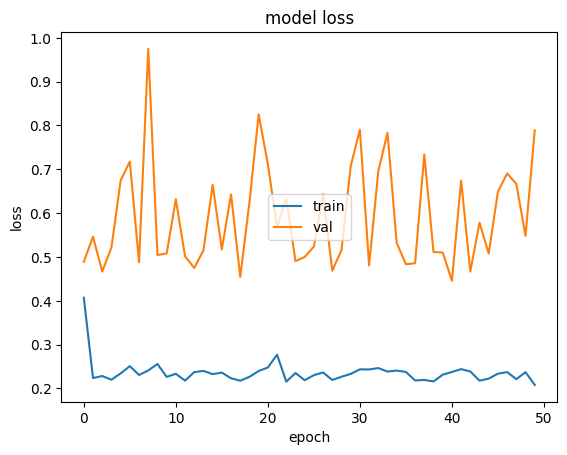

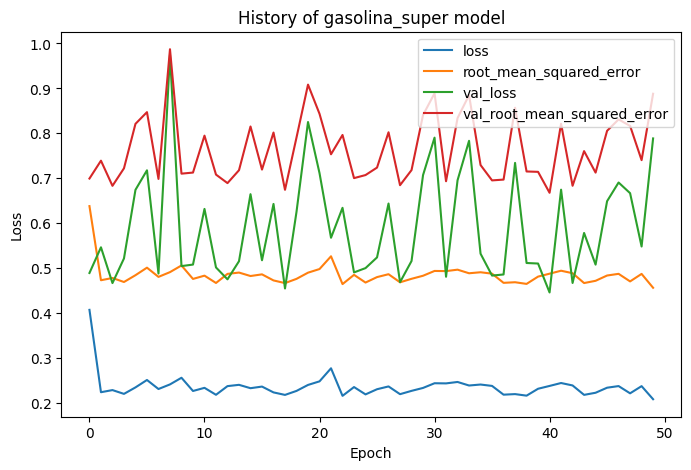

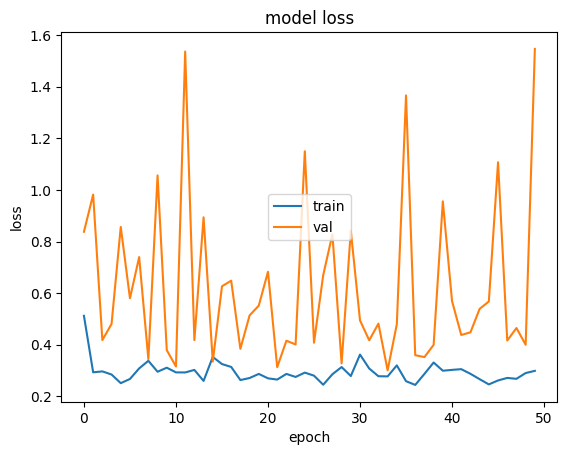

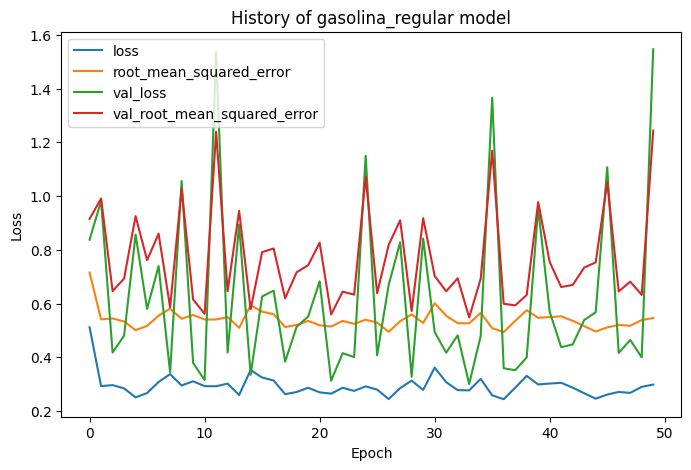

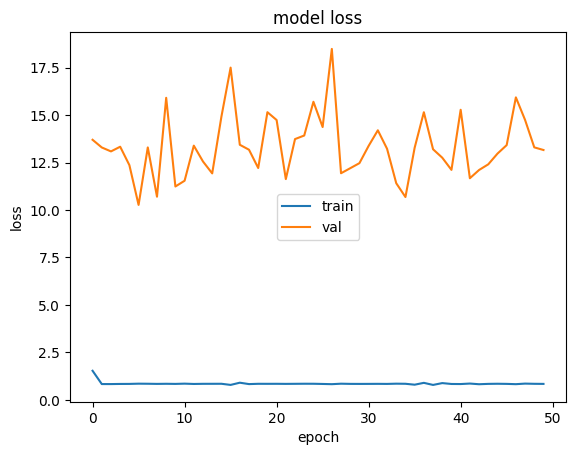

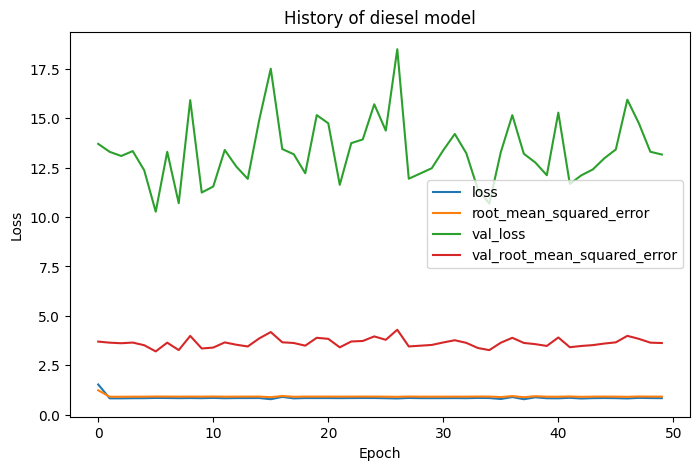

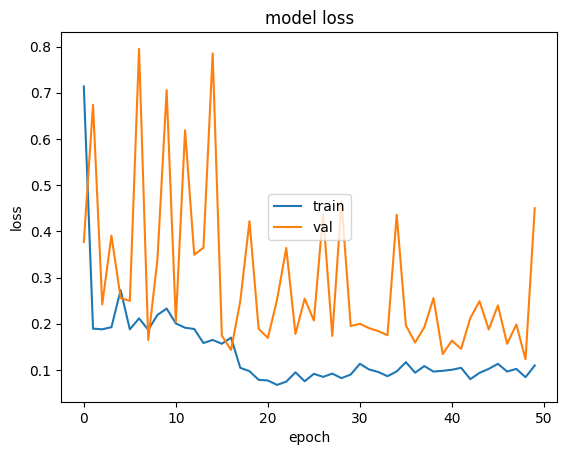

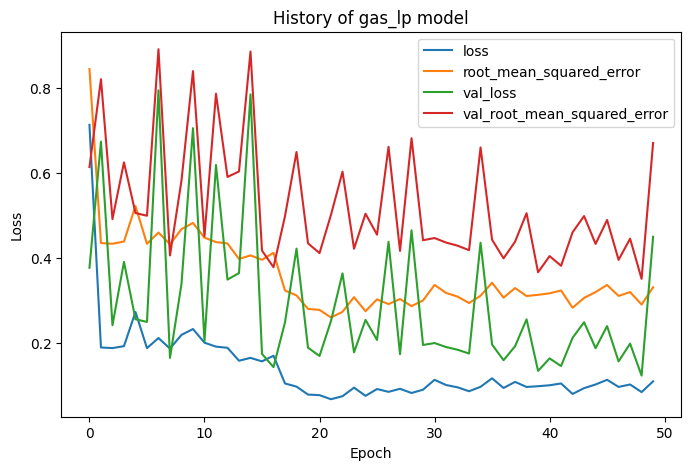

In [61]:
# Graphs history of cosumo models
for key, history in history_consumo.items():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='center')
    plt.show()
    df_history = pd.DataFrame(history.history)
    df_history.plot(figsize=(8,5))
    plt.title(f'History of {key} model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Realizamos un tunneo de hiperparametros para realizar el siguiente modelo. 

In [62]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from concurrent.futures import ThreadPoolExecutor, as_completed

# Parámetros a ajustar
lotes = [32, 64]
tasa_aprendizaje = [0.001, 0.01]
tamaños_lote = [16, 32]
épocas = [20, 30, 50]

def crear_modelo(lote, lr):
    inputs = Input((paso, caracteristicas))
    lstm_out = LSTM(lote)(inputs)
    outputs = Dense(1)(lstm_out)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=lr),
        metrics=[RootMeanSquaredError()]
    )
    return model

def entrenar_modelo(params):
    lote, lr, tamaño_lote, epoch = params

    model = crear_modelo(lote, lr)

    mejor_pérdida_local = float('inf')
    
    # Entrena el modelo
    for key, data in data_consumo.items():
        x_train, y_train = data['train']
        x_val, y_val = data['validation']
        x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
        x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
        
        history = model.fit(
            x_train, 
            y_train, 
            epochs=epoch, 
            validation_data=(x_val, y_val),
            batch_size=tamaño_lote,
            verbose=0
        )
        
        # Evalúa el modelo
        pérdida = min(history.history['val_loss'])
        if pérdida < mejor_pérdida_local:
            mejor_pérdida_local = pérdida
    
    return (lote, lr, tamaño_lote, epoch, mejor_pérdida_local)

# Genera todas las combinaciones de parámetros
combinaciones = [(lote, lr, tamaño_lote, epoch) for lote in lotes 
                                              for lr in tasa_aprendizaje 
                                              for tamaño_lote in tamaños_lote 
                                              for epoch in épocas]
                                              



In [63]:
# Train best model to key
for key, model in consumo_models.items():
    print(f'Training best model for {key}')
    x_train, y_train = data_consumo[key]['train']
    x_val, y_val = data_consumo[key]['validation']
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],1)
    mejor_pérdida = float('inf')

    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(entrenar_modelo, params): params for params in combinaciones}
        
        for future in as_completed(futures):
            lote, lr, tamaño_lote, epoch, pérdida = future.result()
            
            print(f"Combinación {futures[future]}: Pérdida de validación: {pérdida}")
            
            if pérdida < mejor_pérdida:
                mejor_pérdida = pérdida
                mejores_modelos = {'lote': lote, 'lr': lr, 'tamaño_lote': tamaño_lote, 'épocas': epoch}
    
    print(f"Mejores parámetros para {key}: {mejores_modelos}")
    consumo_models[key] = crear_modelo(mejores_modelos['lote'], mejores_modelos['lr'])
    history = consumo_models[key].fit(x_train, 
              y_train, 
              epochs=mejores_modelos['épocas'], 
              validation_data=(x_val, y_val),
              batch_size=mejores_modelos['tamaño_lote'],
                verbose=1)
    
    history_consumo[key] = history
                

Training best model for gasolina_super
Combinación (32, 0.01, 32, 20): Pérdida de validación: 0.12993492186069489
Combinación (32, 0.001, 32, 20): Pérdida de validación: 0.1559160351753235
Combinación (32, 0.01, 16, 20): Pérdida de validación: 0.1355324387550354
Combinación (32, 0.001, 16, 20): Pérdida de validación: 0.15798820555210114
Combinación (32, 0.01, 32, 30): Pérdida de validación: 0.13014717400074005
Combinación (32, 0.001, 32, 30): Pérdida de validación: 0.15274615585803986
Combinación (32, 0.001, 16, 30): Pérdida de validación: 0.1515343338251114
Combinación (32, 0.01, 16, 30): Pérdida de validación: 0.12910625338554382
Combinación (32, 0.01, 32, 50): Pérdida de validación: 0.12959474325180054
Combinación (32, 0.001, 32, 50): Pérdida de validación: 0.15464676916599274
Combinación (64, 0.001, 16, 20): Pérdida de validación: 0.1453048139810562
Combinación (64, 0.001, 32, 20): Pérdida de validación: 0.13974417746067047
Combinación (32, 0.001, 16, 50): Pérdida de validación: 0.

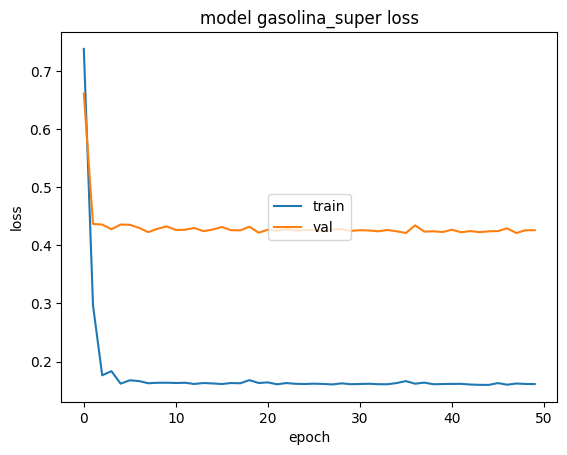

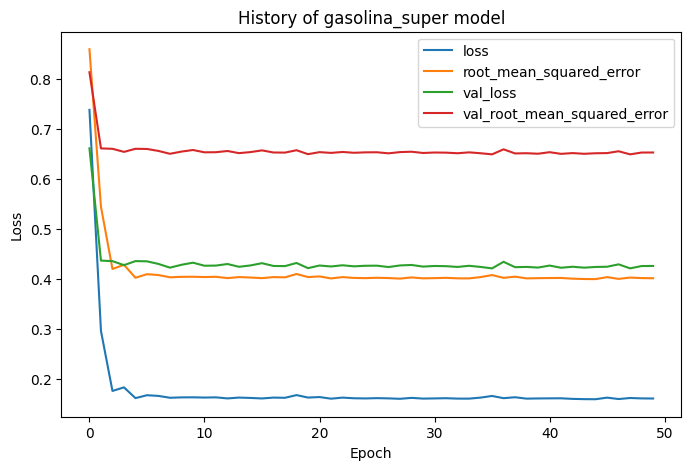

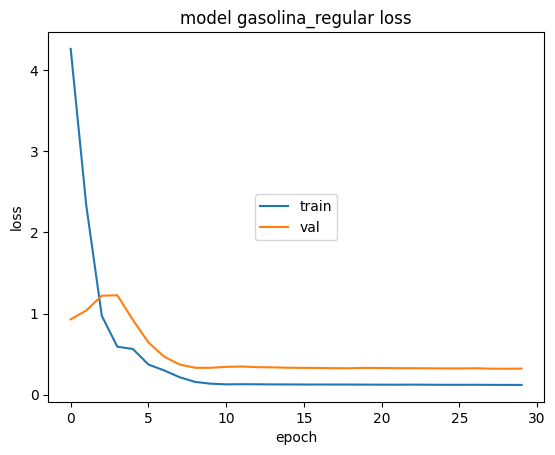

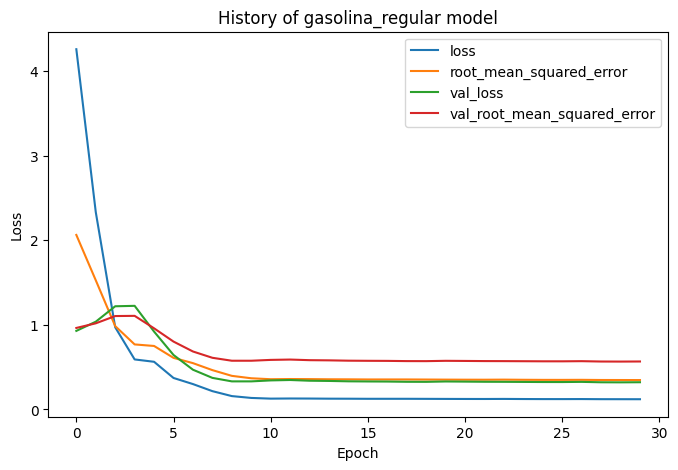

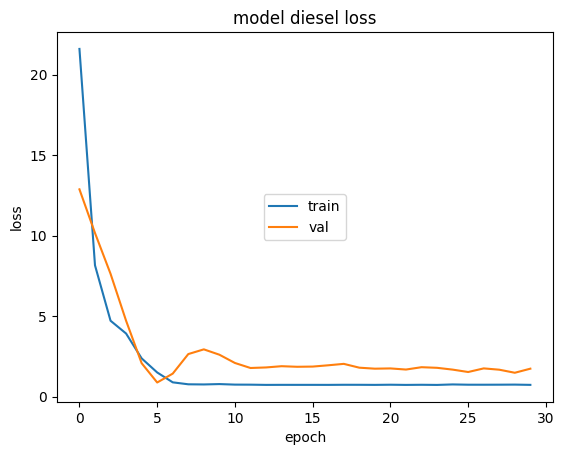

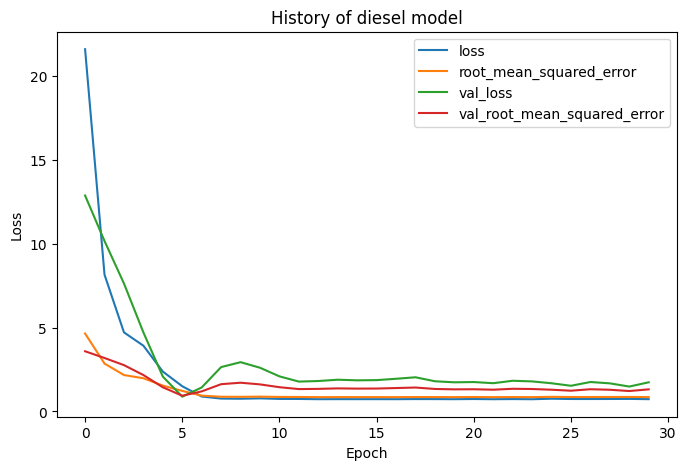

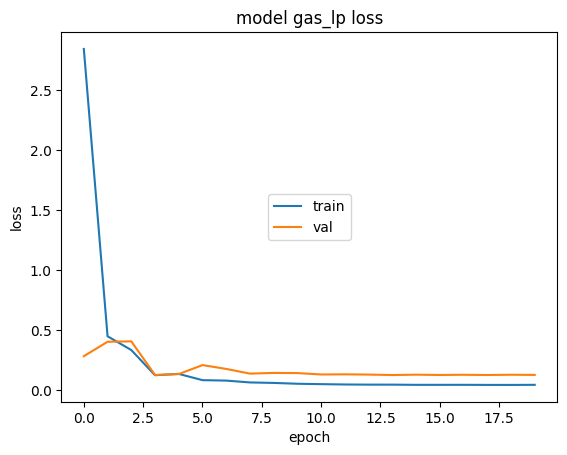

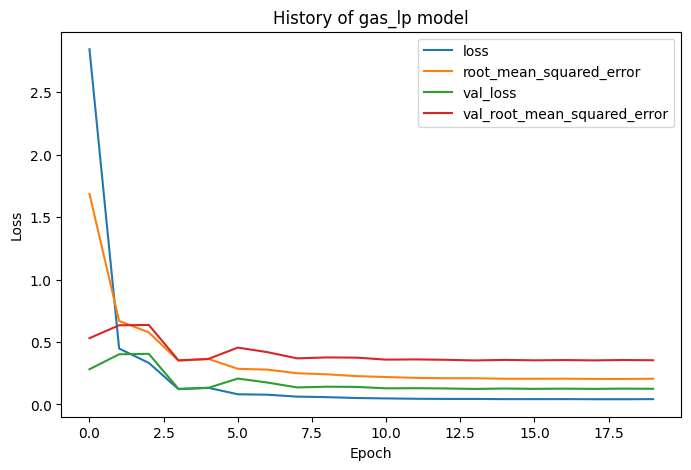

In [64]:
# Graphs history of cosumo models
for key, history in history_consumo.items():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'model {key} loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='center')
    plt.show()
    df_history = pd.DataFrame(history.history)
    df_history.plot(figsize=(8,5))
    plt.title(f'History of {key} model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Luego los de importacion.

In [65]:
history_importacion = {}
# Train models with 50 epochs
for key, model in importacion_models.items():
    x_train, y_train = data_importacion[key]['train']
    x_val, y_val = data_importacion[key]['validation']
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],1)
    history = model.fit(x_train, 
              y_train, 
              epochs=100, 
              validation_data=(x_val, y_val),
              batch_size=1,
                verbose=1)
    history_importacion[key] = history

importacion_first_models = importacion_models.copy()

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1620 - root_mean_squared_error: 1.0764 - val_loss: 1.0740 - val_root_mean_squared_error: 1.0363
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1987 - root_mean_squared_error: 1.0937 - val_loss: 1.1134 - val_root_mean_squared_error: 1.0552
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9507 - root_mean_squared_error: 0.9707 - val_loss: 1.1062 - val_root_mean_squared_error: 1.0517
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9125 - root_mean_squared_error: 0.9439 - val_loss: 1.0893 - val_root_mean_squared_error: 1.0437
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0934 - root_mean_squared_error: 1.0438 - val_loss: 1.1653 - val_root_mean_squared_error: 1.0795
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0675 - root_mean_squared_error: 1.0300 - val_loss: 1.1313 - val_root_mean_squared_error: 1.0636
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

Graficamos el proceso de entrenamiento de los modelos.

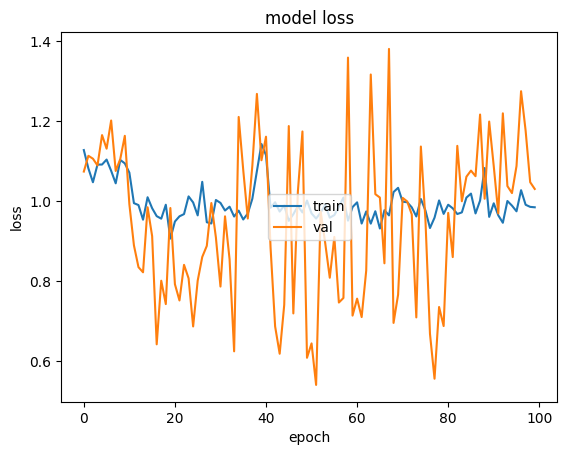

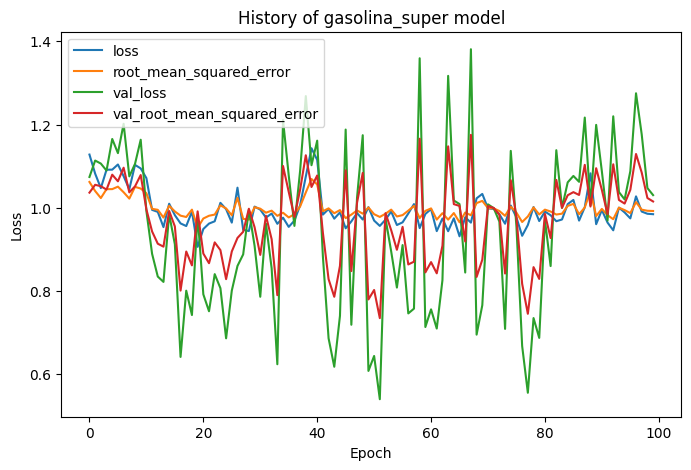

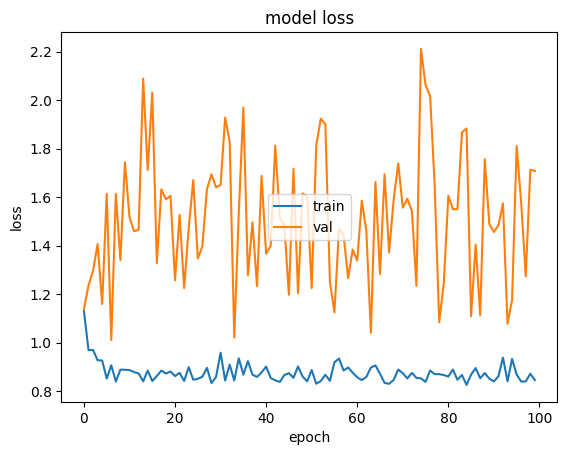

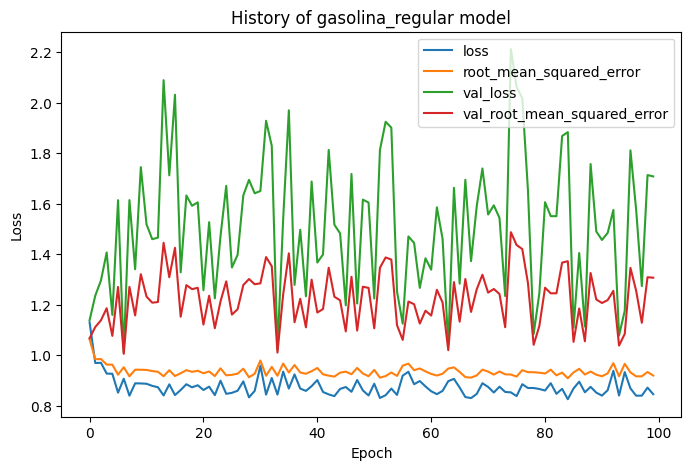

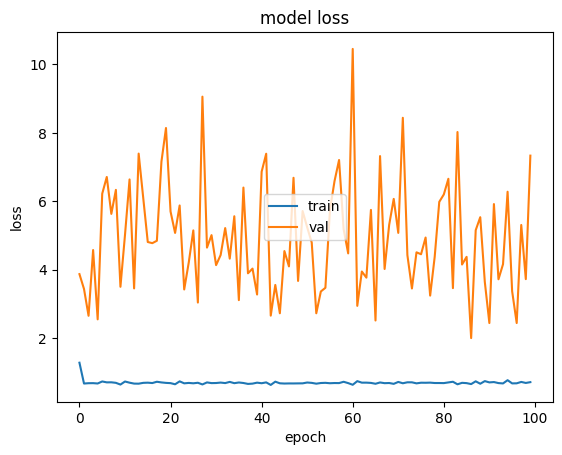

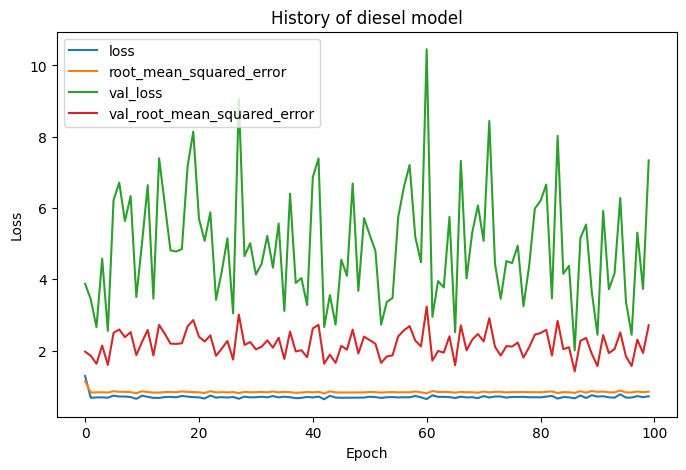

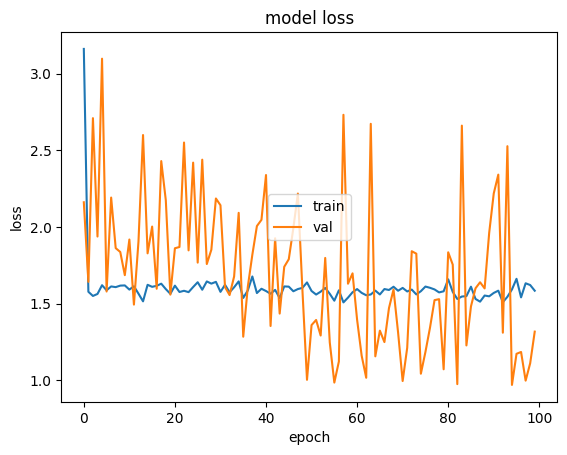

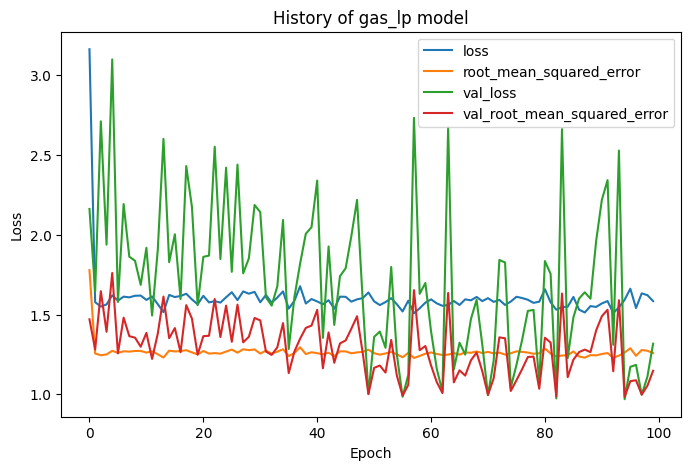

In [66]:
# Graph historys of importacion models
for key, history in history_importacion.items():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='center')
    plt.show()
    df_history = pd.DataFrame(history.history)
    df_history.plot(figsize=(8,5))
    plt.title(f'History of {key} model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Se realiza un nuevo modelo tunneando los hiperparametros del modelo y su entrenamiento. 

In [67]:
# Train best model to key
for key, model in importacion_models.items():
    print(f'Training best model for {key}')
    x_train, y_train = data_importacion[key]['train']
    x_val, y_val = data_importacion[key]['validation']
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],1)
    mejor_pérdida = float('inf')

    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(entrenar_modelo, params): params for params in combinaciones}
        
        for future in as_completed(futures):
            lote, lr, tamaño_lote, epoch, pérdida = future.result()
            
            print(f"Combinación {futures[future]}: Pérdida de validación: {pérdida}")
            
            if pérdida < mejor_pérdida:
                mejor_pérdida = pérdida
                mejores_modelos = {'lote': lote, 'lr': lr, 'tamaño_lote': tamaño_lote, 'épocas': epoch}
    
    print(f"Mejores parámetros para {key}: {mejores_modelos}")
    importacion_models[key] = crear_modelo(mejores_modelos['lote'], mejores_modelos['lr'])
    history = importacion_models[key].fit(x_train, 
              y_train, 
              epochs=mejores_modelos['épocas'], 
              validation_data=(x_val, y_val),
              batch_size=mejores_modelos['tamaño_lote'],
                verbose=1)
    
    history_importacion[key] = history

Training best model for gasolina_super
Combinación (32, 0.001, 32, 20): Pérdida de validación: 0.16082467138767242
Combinación (32, 0.01, 32, 20): Pérdida de validación: 0.13027000427246094
Combinación (32, 0.001, 16, 20): Pérdida de validación: 0.15091706812381744
Combinación (32, 0.01, 16, 20): Pérdida de validación: 0.13308200240135193
Combinación (32, 0.01, 32, 30): Pérdida de validación: 0.12464589625597
Combinación (32, 0.001, 32, 30): Pérdida de validación: 0.1565334051847458
Combinación (32, 0.01, 16, 30): Pérdida de validación: 0.1298210620880127
Combinación (32, 0.001, 16, 30): Pérdida de validación: 0.150811105966568
Combinación (32, 0.001, 32, 50): Pérdida de validación: 0.15561600029468536
Combinación (32, 0.01, 32, 50): Pérdida de validación: 0.12422312051057816
Combinación (64, 0.001, 32, 20): Pérdida de validación: 0.13812272250652313
Combinación (64, 0.001, 16, 20): Pérdida de validación: 0.14555369317531586
Combinación (32, 0.01, 16, 50): Pérdida de validación: 0.1306

Graficamos el nuevo entrenamiento. 

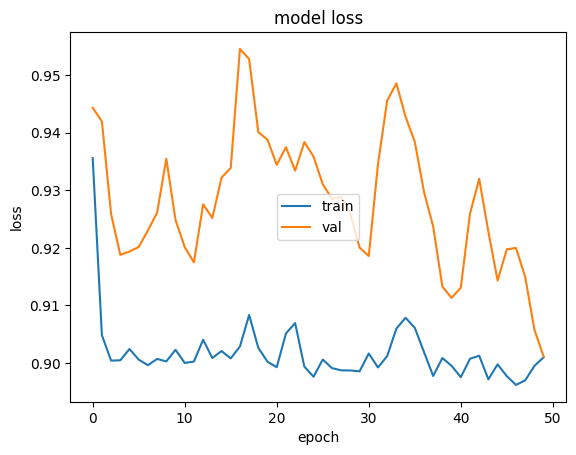

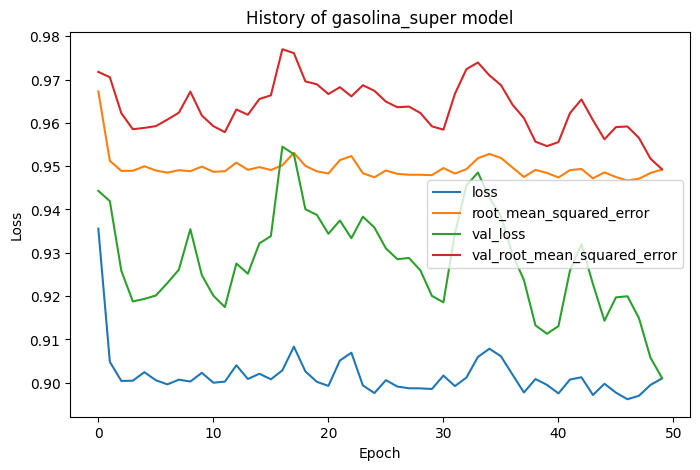

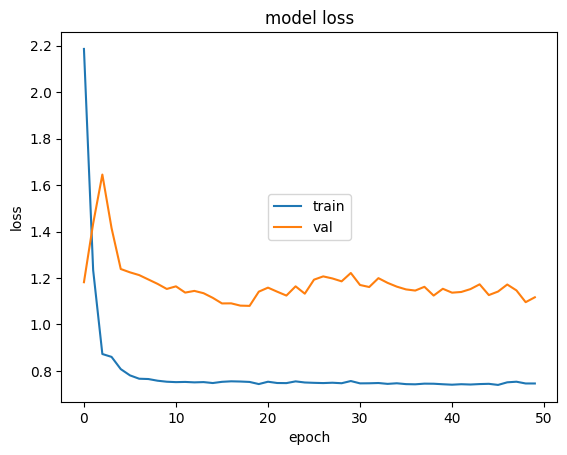

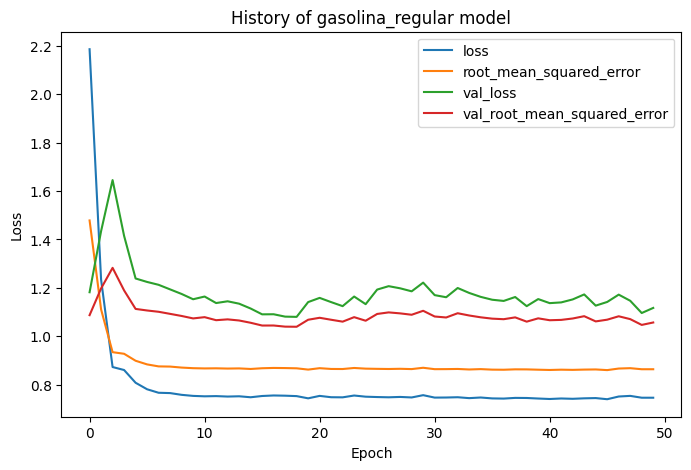

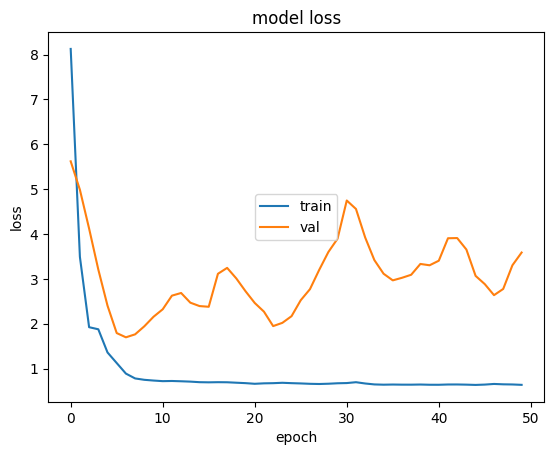

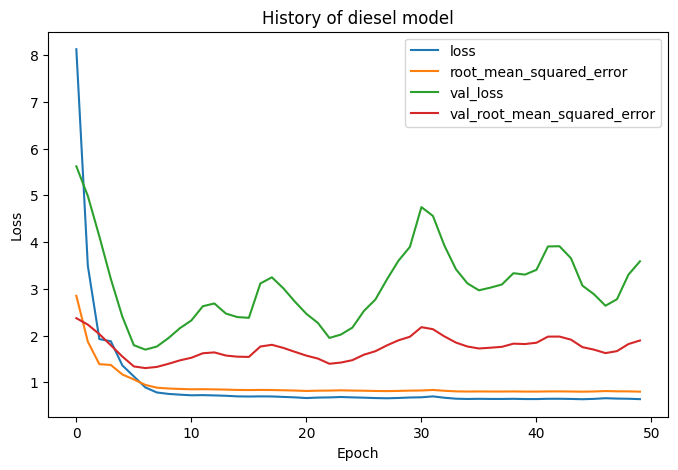

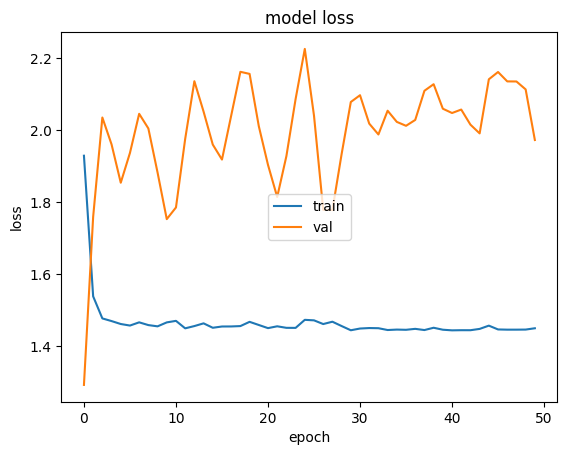

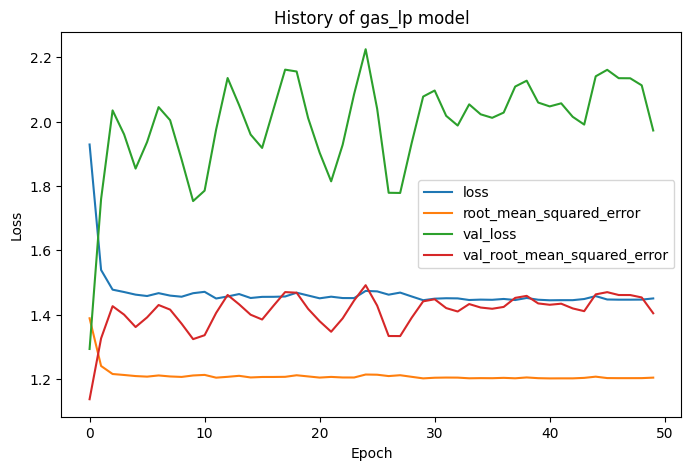

In [68]:
# Graph historys of importacion models
for key, history in history_importacion.items():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='center')
    plt.show()
    df_history = pd.DataFrame(history.history)
    df_history.plot(figsize=(8,5))
    plt.title(f'History of {key} model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Por último los de precios. Se puede ver que estos tienen muy poca perdida en sus datos. 

In [69]:
history_precios = {}
# Train models with 50 epochs
for key, model in precios_models.items():
    x_train, y_train = data_precios[key]['train']
    x_val, y_val = data_precios[key]['validation']
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],1)
    history = model.fit(x_train, 
              y_train, 
              epochs=50, 
              validation_data=(x_val, y_val),
              batch_size=1,
                verbose=1)
    history_precios[key] = history

precios_first_models = precios_models.copy()

Epoch 1/50
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8444 - root_mean_squared_error: 0.7574 - val_loss: 2.6328 - val_root_mean_squared_error: 1.6226
Epoch 2/50
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.1891e-09 - root_mean_squared_error: 6.4613e-05 - val_loss: 2.6328 - val_root_mean_squared_error: 1.6226
Epoch 3/50
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.6921e-09 - root_mean_squared_error: 7.5342e-05 - val_loss: 2.6327 - val_root_mean_squared_error: 1.6226
Epoch 4/50
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4827e-09 - root_mean_squared_error: 7.3824e-05 - val_loss: 2.6328 - val_root_mean_squared_error: 1.6226
Epoch 5/50
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3086e-09 - root_mean_squared_error: 8.5396e-05 - val_loss: 2.6328 - val_root_mean_squared_error: 1.6226
Epoch 6/50
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.3822e-09 - root_mean_squared_error: 9.6652e-05 - val_loss: 2.6328 - val_root_mean_squared_error: 1.6226
Epoch 7/50
7

Graficamos el proceso de entrenamiento de los modelos. 


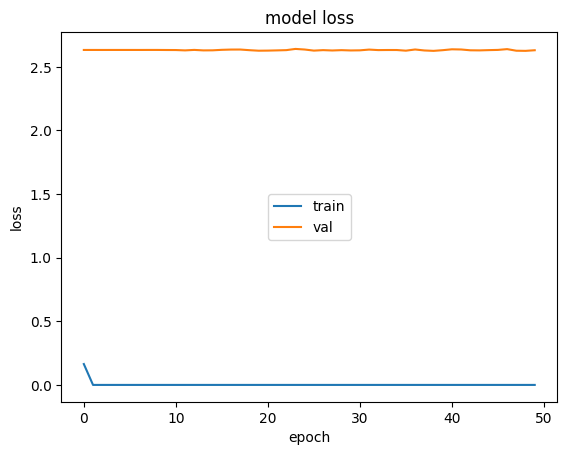

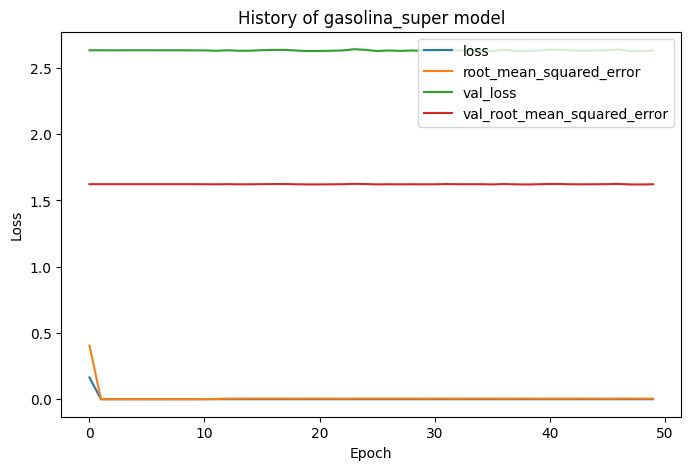

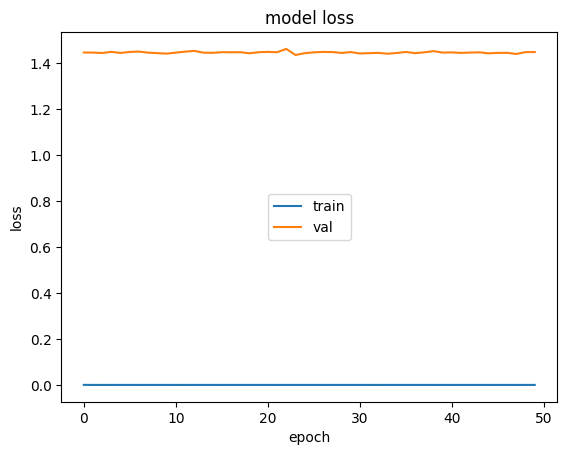

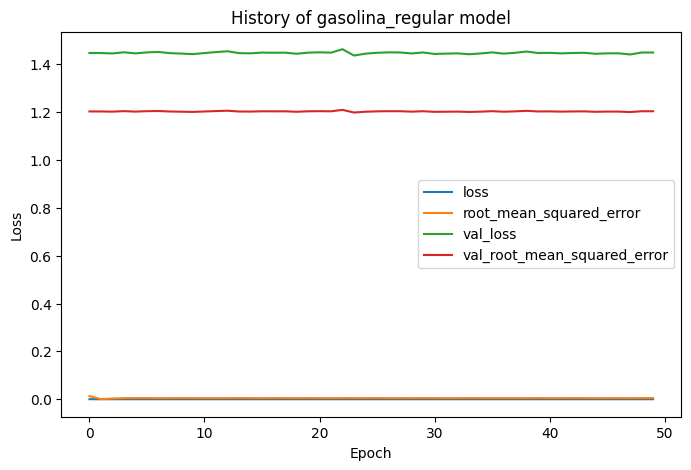

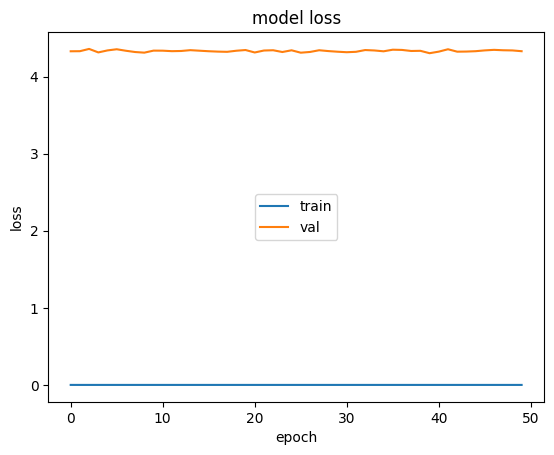

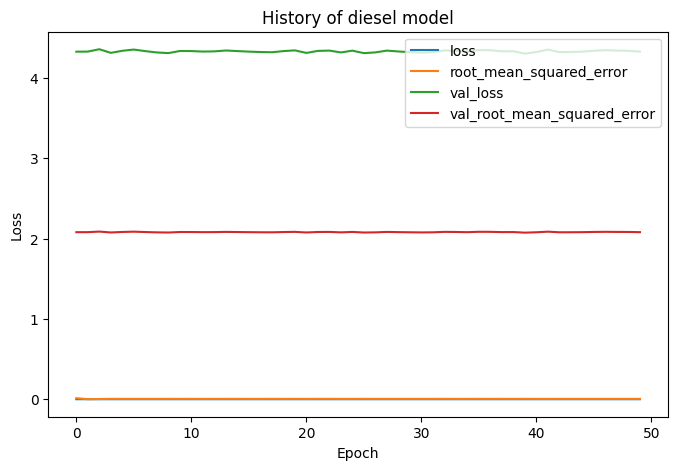

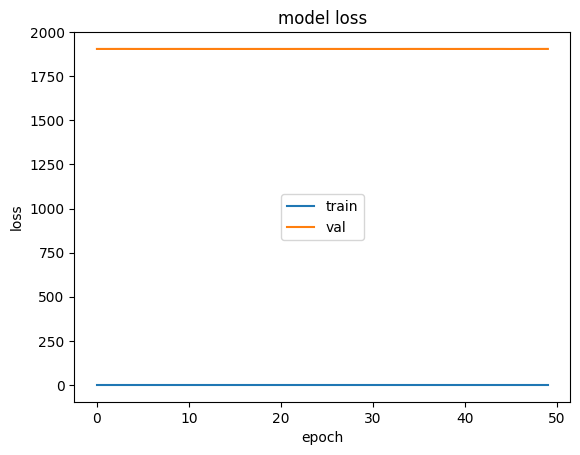

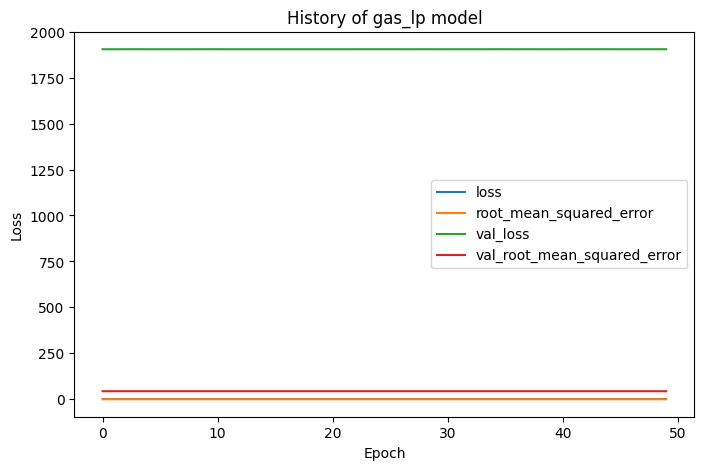

In [70]:
# Graph historys of precios models
for key, history in history_precios.items():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='center')
    plt.show()
    df_history = pd.DataFrame(history.history)
    df_history.plot(figsize=(8,5))
    plt.title(f'History of {key} model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


En este caso los valores son mas consistentes y tiene mejor control de la perdida. Por lo que se nota que aprende bien. Aun asi por si acaso se tunnea el modelo.

In [71]:
# Train best model to key
for key, model in precios_models.items():
    print(f'Training best model for {key}')
    x_train, y_train = data_precios[key]['train']
    x_val, y_val = data_precios[key]['validation']
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],1)
    mejor_pérdida = float('inf')

    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(entrenar_modelo, params): params for params in combinaciones}
        
        for future in as_completed(futures):
            lote, lr, tamaño_lote, epoch, pérdida = future.result()
            
            print(f"Combinación {futures[future]}: Pérdida de validación: {pérdida}")
            
            if pérdida < mejor_pérdida:
                mejor_pérdida = pérdida
                mejores_modelos = {'lote': lote, 'lr': lr, 'tamaño_lote': tamaño_lote, 'épocas': epoch}
    
    print(f"Mejores parámetros para {key}: {mejores_modelos}")
    precios_models[key] = crear_modelo(mejores_modelos['lote'], mejores_modelos['lr'])
    history = precios_models[key].fit(x_train, 
              y_train, 
              epochs=mejores_modelos['épocas'], 
              validation_data=(x_val, y_val),
              batch_size=mejores_modelos['tamaño_lote'],
                verbose=1)
    
    history_precios[key] = history
                

Training best model for gasolina_super
Combinación (32, 0.01, 32, 20): Pérdida de validación: 0.14242595434188843
Combinación (32, 0.001, 32, 20): Pérdida de validación: 0.15742817521095276
Combinación (32, 0.001, 16, 20): Pérdida de validación: 0.15744464099407196
Combinación (32, 0.01, 16, 20): Pérdida de validación: 0.13338303565979004
Combinación (32, 0.001, 32, 30): Pérdida de validación: 0.1563505083322525
Combinación (32, 0.01, 32, 30): Pérdida de validación: 0.12607498466968536
Combinación (32, 0.001, 16, 30): Pérdida de validación: 0.15256810188293457
Combinación (32, 0.01, 16, 30): Pérdida de validación: 0.1325686126947403
Combinación (32, 0.001, 32, 50): Pérdida de validación: 0.15507236123085022
Combinación (32, 0.01, 32, 50): Pérdida de validación: 0.1241764947772026
Combinación (64, 0.001, 16, 20): Pérdida de validación: 0.14489981532096863
Combinación (64, 0.001, 32, 20): Pérdida de validación: 0.13771222531795502
Combinación (32, 0.01, 16, 50): Pérdida de validación: 0.

Graficamos el entrenamiento del modelo tunneado.

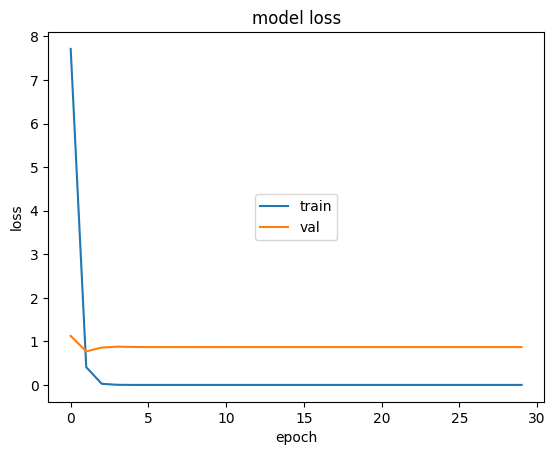

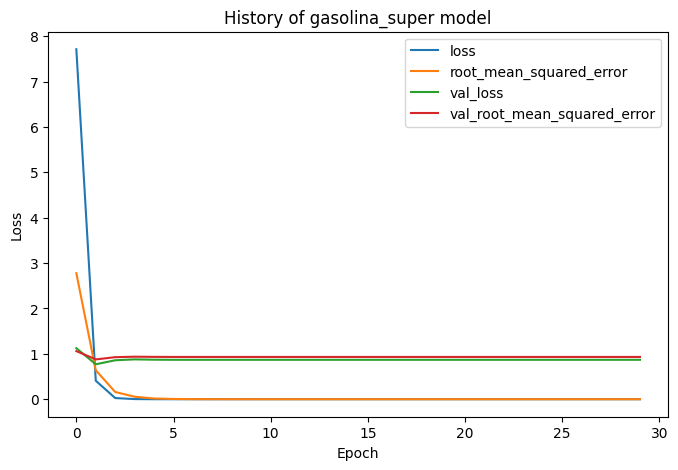

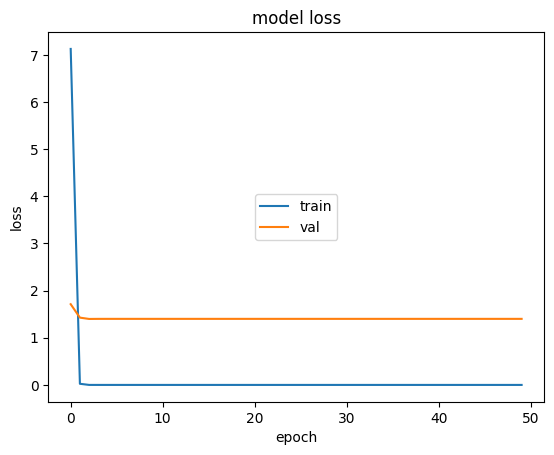

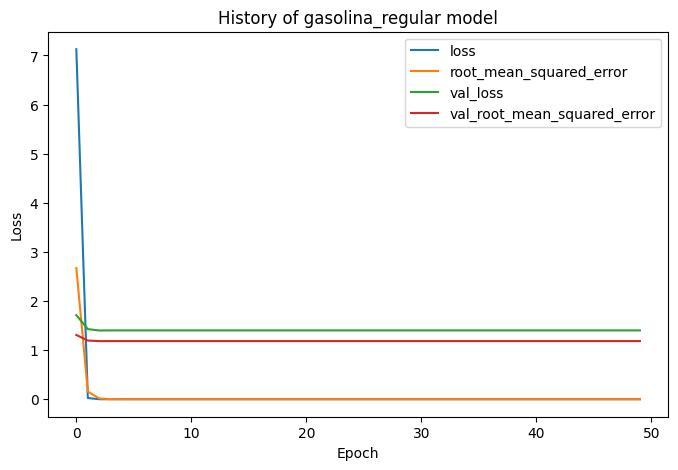

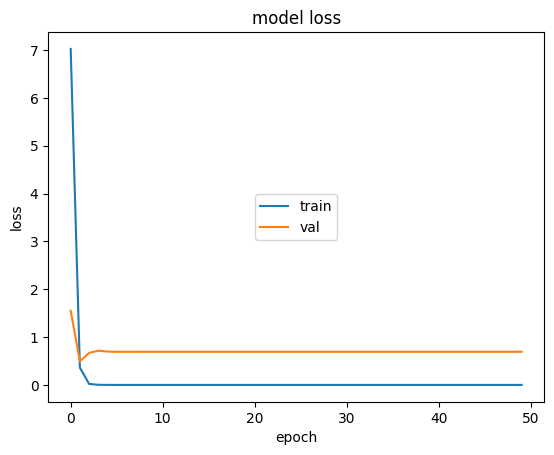

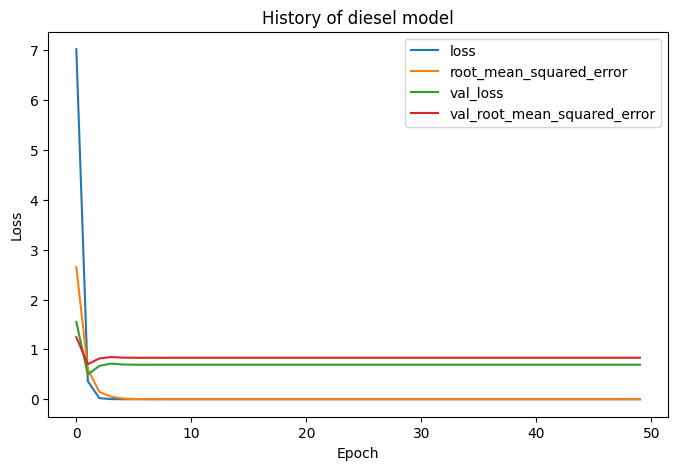

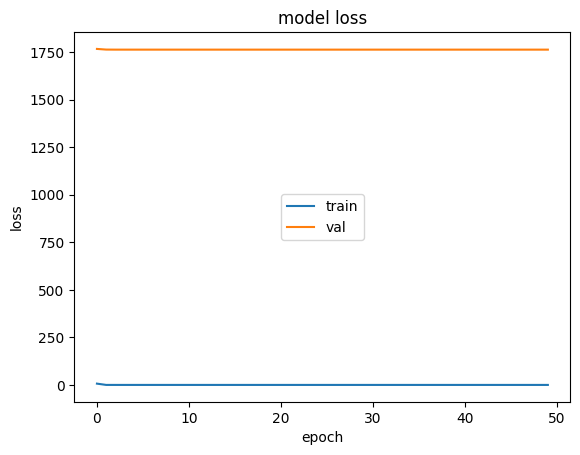

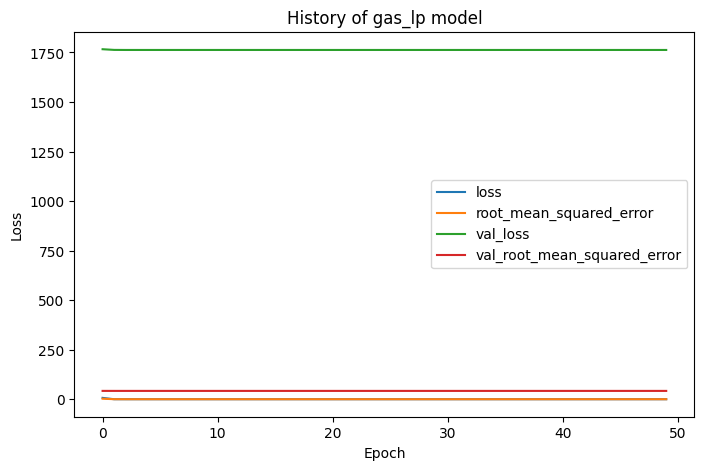

In [72]:
# Graph historys of precios models
for key, history in history_precios.items():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='center')
    plt.show()
    df_history = pd.DataFrame(history.history)
    df_history.plot(figsize=(8,5))
    plt.title(f'History of {key} model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

#### Evaluamos los modelos.

In [74]:
print("------------------------------------")

# Función para evaluar un modelo
def evaluar_modelo(model, x, y, tipo_datos):
    try:
        loss = model.evaluate(x, y, verbose=1)
        print(f"{tipo_datos} loss: {loss}")
    except Exception as e:
        print(f"Error evaluating {tipo_datos}: {e}")

for key, model in consumo_first_models.items():
    x_train, y_train = data_consumo[key]['train']
    x_test, y_test = data_consumo[key]['test']
    x_val, y_val = data_consumo[key]['validation']

    print(f"Consumo model for {key}")
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

    evaluar_modelo(model, x_train, y_train, "Train")
    evaluar_modelo(model, x_test, y_test, "Test")
    evaluar_modelo(model, x_val, y_val, "Validation")
    print("\n")

print("------------------------------------")

for key, model in importacion_first_models.items():
    x_train, y_train = data_importacion[key]['train']
    x_test, y_test = data_importacion[key]['test']
    x_val, y_val = data_importacion[key]['validation']

    print(f"Importación model for {key}")
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

    evaluar_modelo(model, x_train, y_train, "Train")
    evaluar_modelo(model, x_test, y_test, "Test")
    evaluar_modelo(model, x_val, y_val, "Validation")
    print("\n")

print("------------------------------------")

for key, model in precios_first_models.items():
    x_train, y_train = data_precios[key]['train']
    x_test, y_test = data_precios[key]['test']
    x_val, y_val = data_precios[key]['validation']

    print(f"Precios model for {key}")
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

    evaluar_modelo(model, x_train, y_train, "Train")
    evaluar_modelo(model, x_test, y_test, "Test")
    evaluar_modelo(model, x_val, y_val, "Validation")
    print("\n")

print("------------------------------------")

------------------------------------
Consumo model for gasolina_super
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7984 - root_mean_squared_error: 1.3152  
Train loss: [2.284528970718384, 1.5114657878875732]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4815 - root_mean_squared_error: 1.8644 
Test loss: [3.672616481781006, 1.9164072275161743]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.4529 - root_mean_squared_error: 2.1102
Validation loss: [4.452903747558594, 2.1101903915405273]


Consumo model for gasolina_regular
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9884 - root_mean_squared_error: 2.4453  
Train loss: [6.15604305267334, 2.48113751411438]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.5060 - root_mean_squared_error: 3.9355 
Test loss: [16.24503517150879, 4.030512809753418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.4399 - root_mean_squared_error: 1.5620
Validation loss: [2.439873695373535, 1.5620094537734985]


Consumo model for diesel
8/8 ━━━━━━━━━━━━━━━━━━━━ 

In [75]:
print("------------------------------------")

# Función para evaluar un modelo
def evaluar_modelo(model, x, y, tipo_datos):
    try:
        loss = model.evaluate(x, y, verbose=1)
        print(f"{tipo_datos} loss: {loss}")
    except Exception as e:
        print(f"Error evaluating {tipo_datos}: {e}")

for key, model in consumo_models.items():
    x_train, y_train = data_consumo[key]['train']
    x_test, y_test = data_consumo[key]['test']
    x_val, y_val = data_consumo[key]['validation']

    # Asegúrate de que x_train, x_test, y_train, y_test tengan las dimensiones correctas
    print(f"Consumo model for {key}")
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

    evaluar_modelo(model, x_train, y_train, "Train")
    evaluar_modelo(model, x_test, y_test, "Test")
    evaluar_modelo(model, x_val, y_val, "Validation")
    print("\n")

print("------------------------------------")

for key, model in importacion_models.items():
    x_train, y_train = data_importacion[key]['train']
    x_test, y_test = data_importacion[key]['test']
    x_val, y_val = data_importacion[key]['validation']

    print(f"Importación model for {key}")
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

    evaluar_modelo(model, x_train, y_train, "Train")
    evaluar_modelo(model, x_test, y_test, "Test")
    evaluar_modelo(model, x_val, y_val, "Validation")
    print("\n")

print("------------------------------------")

for key, model in precios_models.items():
    x_train, y_train = data_precios[key]['train']
    x_test, y_test = data_precios[key]['test']
    x_val, y_val = data_precios[key]['validation']

    print(f"Precios model for {key}")
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

    evaluar_modelo(model, x_train, y_train, "Train")
    evaluar_modelo(model, x_test, y_test, "Test")
    evaluar_modelo(model, x_val, y_val, "Validation")
    print("\n")

print("------------------------------------")


------------------------------------
Consumo model for gasolina_super
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1432 - root_mean_squared_error: 0.3781 
Train loss: [0.15976418554782867, 0.39970511198043823]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9937 - root_mean_squared_error: 0.9968 
Test loss: [0.9844838380813599, 0.9922115802764893]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4260 - root_mean_squared_error: 0.6527
Validation loss: [0.42602232098579407, 0.6527038812637329]


Consumo model for gasolina_regular
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0835 - root_mean_squared_error: 0.2844 
Train loss: [0.12007120996713638, 0.34651294350624084]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4483 - root_mean_squared_error: 1.2025 
Test loss: [1.527565836906433, 1.2359473705291748]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3217 - root_mean_squared_error: 0.5671
Validation loss: [0.32165759801864624, 0.5671486854553223]


Consumo model for diesel
8/8 ━━━━━━━━━

### Predecir usando los modelos. 

In [76]:
def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion

In [77]:
# Predicciones de consumo
predict_consumo_test = {}

super_consumo_test_pred = prediccion_fun(serie_gasolina_super_test,consumo_models['gasolina_super'],1,scaler_consumo)
predict_consumo_test['gasolina_super'] = super_consumo_test_pred

regular_consumo_test_pred = prediccion_fun(serie_gasolina_regular_test,consumo_models['gasolina_regular'],1,scaler_consumo)
predict_consumo_test['gasolina_regular'] = regular_consumo_test_pred

diesel_consumo_test_pred = prediccion_fun(serie_diesel_test,consumo_models['diesel'],1,scaler_consumo)
predict_consumo_test['diesel'] = diesel_consumo_test_pred

gl_consumo_test_pred = prediccion_fun(serie_gas_lp_test,consumo_models['gas_lp'],1,scaler_consumo)
predict_consumo_test['gas_lp'] = gl_consumo_test_pred

# Predicciones de importación
predict_importacion_test = {}

super_importacion_test_pred = prediccion_fun(serie_gasolina_super_import_test,importacion_models['gasolina_super'],1,scaler_import)
predict_importacion_test['gasolina_super'] = super_importacion_test_pred

regular_importacion_test_pred = prediccion_fun(serie_gasolina_regular_import_test,importacion_models['gasolina_regular'],1,scaler_import)
predict_importacion_test['gasolina_regular'] = regular_importacion_test_pred

diesel_importacion_test_pred = prediccion_fun(serie_diesel_import_test,importacion_models['diesel'],1,scaler_import)
predict_importacion_test['diesel'] = diesel_importacion_test_pred

gl_importacion_test_pred = prediccion_fun(serie_gas_lp_import_test,importacion_models['gas_lp'],1,scaler_import)
predict_importacion_test['gas_lp'] = gl_importacion_test_pred

# Predicciones de precios
predict_precios_test = {}

super_precios_test_pred = prediccion_fun(serie_gasolina_super_precios_test,precios_models['gasolina_super'],1,scaler)
predict_precios_test['gasolina_super'] = super_precios_test_pred

regular_precios_test_pred = prediccion_fun(serie_gasolina_regular_precios_test,precios_models['gasolina_regular'],1,scaler)
predict_precios_test['gasolina_regular'] = regular_precios_test_pred

diesel_precios_test_pred = prediccion_fun(serie_diesel_precios_test,precios_models['diesel'],1,scaler)
predict_precios_test['diesel'] = diesel_precios_test_pred

gl_precios_test_pred = prediccion_fun(serie_gas_lp_precios_test,precios_models['gas_lp'],1,scaler)
predict_precios_test['gas_lp'] = gl_precios_test_pred


In [78]:
# Predicciones de consumo con validation
predict_consumo_validation = {}

super_consumo_validation_pred = prediccion_fun(serie_gasolina_super_validation,consumo_models['gasolina_super'],1,scaler_consumo)
predict_consumo_validation['gasolina_super'] = super_consumo_validation_pred

regular_consumo_validation_pred = prediccion_fun(serie_gasolina_regular_validation,consumo_models['gasolina_regular'],1,scaler_consumo)
predict_consumo_validation['gasolina_regular'] = regular_consumo_validation_pred

diesel_consumo_validation_pred = prediccion_fun(serie_diesel_validation,consumo_models['diesel'],1,scaler_consumo)
predict_consumo_validation['diesel'] = diesel_consumo_validation_pred

gl_consumo_validation_pred = prediccion_fun(serie_gas_lp_validation,consumo_models['gas_lp'],1,scaler_consumo)
predict_consumo_validation['gas_lp'] = gl_consumo_validation_pred


# Predicciones de importación con validation
predict_importacion_validation = {}

super_importacion_validation_pred = prediccion_fun(serie_gasolina_super_import_validation,importacion_models['gasolina_super'],1,scaler_import)
predict_importacion_validation['gasolina_super'] = super_importacion_validation_pred

regular_importacion_validation_pred = prediccion_fun(serie_gasolina_regular_import_validation,importacion_models['gasolina_regular'],1,scaler_import)
predict_importacion_validation['gasolina_regular'] = regular_importacion_validation_pred

diesel_importacion_validation_pred = prediccion_fun(serie_diesel_import_validation,importacion_models['diesel'],1,scaler_import)
predict_importacion_validation['diesel'] = diesel_importacion_validation_pred

gl_importacion_validation_pred = prediccion_fun(serie_gas_lp_import_validation,importacion_models['gas_lp'],1,scaler_import)
predict_importacion_validation['gas_lp'] = gl_importacion_validation_pred

# Predicciones de precios con validation
predict_precios_validation = {}

super_precios_validation_pred = prediccion_fun(serie_gasolina_super_precios_validation,precios_models['gasolina_super'],1,scaler)
predict_precios_validation['gasolina_super'] = super_precios_validation_pred

regular_precios_validation_pred = prediccion_fun(serie_gasolina_regular_precios_validation,precios_models['gasolina_regular'],1,scaler)
predict_precios_validation['gasolina_regular'] = regular_precios_validation_pred

diesel_precios_validation_pred = prediccion_fun(serie_diesel_precios_validation,precios_models['diesel'],1,scaler)
predict_precios_validation['diesel'] = diesel_precios_validation_pred

gl_precios_validation_pred = prediccion_fun(serie_gas_lp_precios_validation,precios_models['gas_lp'],1,scaler)
predict_precios_validation['gas_lp'] = gl_precios_validation_pred



In [79]:
def predictions_df(data, index ):
    df_pred = pd.DataFrame(data, index=index)
    return df_pred

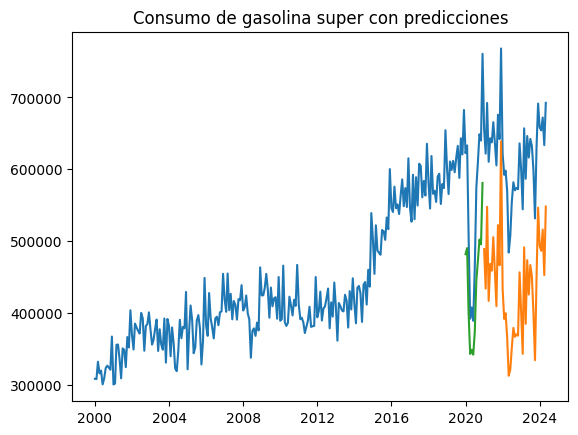

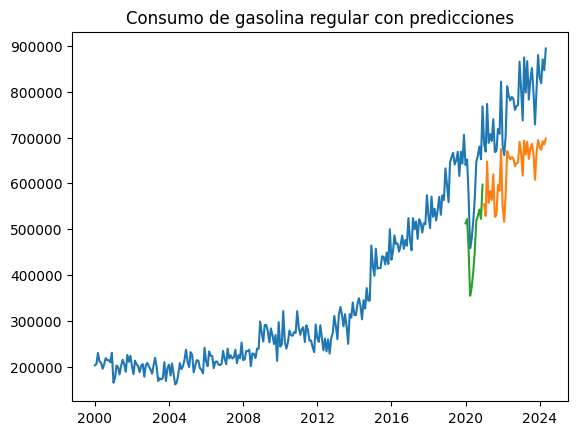

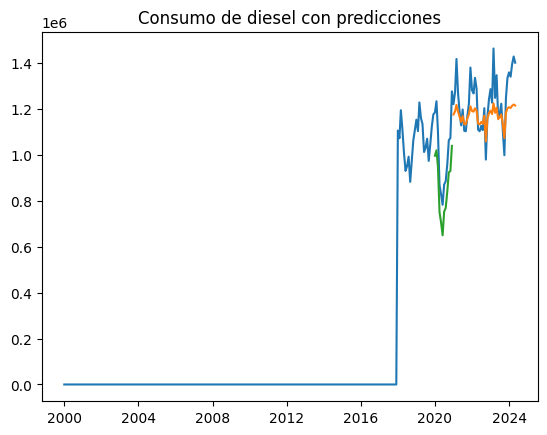

In [85]:
# Predicciones con consumo
# Dataframes de predicciones
df_predict_consumo_test_super = predictions_df(predict_consumo_test['gasolina_super'], index_test_super)
df_predict_consumo_validation_super = predictions_df(predict_consumo_validation['gasolina_super'], index_validation_super)

plt.plot(serie_gasolina_super_)
plt.plot(df_predict_consumo_test_super)
plt.plot(df_predict_consumo_validation_super)
plt.title('Consumo de gasolina super con predicciones')
plt.show()


# Dataframes de predicciones
df_predict_consumo_test_regular = predictions_df(predict_consumo_test['gasolina_regular'], index_test_regular)
df_predict_consumo_validation_regular = predictions_df(predict_consumo_validation['gasolina_regular'], index_validation_regular)

plt.plot(serie_gasolina_regular_)
plt.plot(df_predict_consumo_test_regular)
plt.plot(df_predict_consumo_validation_regular)
plt.title('Consumo de gasolina regular con predicciones')

plt.show()

# Dataframes de predicciones
df_predict_consumo_test_diesel = predictions_df(predict_consumo_test['diesel'], index_test_diesel)
df_predict_consumo_validation_diesel = predictions_df(predict_consumo_validation['diesel'], index_validation_diesel)

plt.plot(serie_diesel_)
plt.plot(df_predict_consumo_test_diesel)
plt.plot(df_predict_consumo_validation_diesel)
plt.title('Consumo de diesel con predicciones')
plt.show()



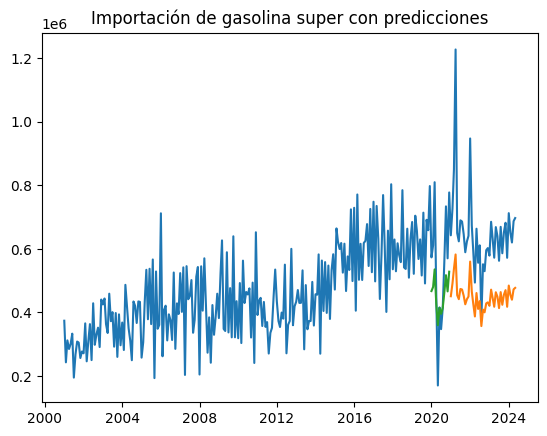

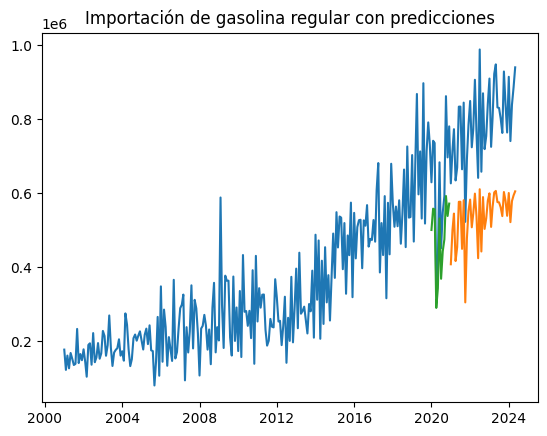

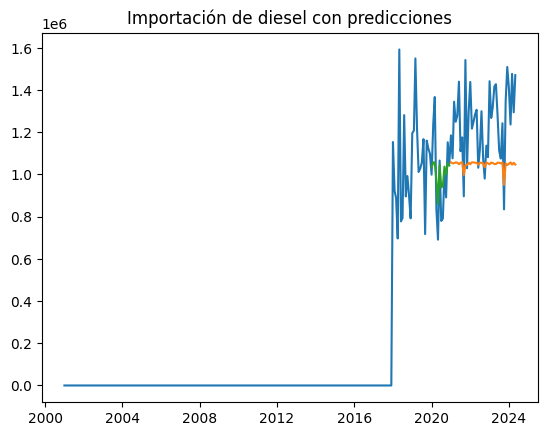

In [86]:
# Predicciones con importación

# Dataframes de predicciones
df_predict_importacion_test_super = predictions_df(predict_importacion_test['gasolina_super'], index_test_import_super)
df_predict_importacion_validation_super = predictions_df(predict_importacion_validation['gasolina_super'], index_import_validation_super)

plt.plot(serie_gasolina_super_import_)
plt.plot(df_predict_importacion_test_super)
plt.plot(df_predict_importacion_validation_super)
plt.title('Importación de gasolina super con predicciones')


plt.show()


# Dataframes de predicciones
df_predict_importacion_test_regular = predictions_df(predict_importacion_test['gasolina_regular'], index_test_import_regular)
df_predict_importacion_validation_regular = predictions_df(predict_importacion_validation['gasolina_regular'], index_import_validation_regular)

plt.plot(serie_gasolina_regular_import_)
plt.plot(df_predict_importacion_test_regular)
plt.plot(df_predict_importacion_validation_regular)
plt.title('Importación de gasolina regular con predicciones')


plt.show()


# Dataframes de predicciones
df_predict_importacion_test_diesel = predictions_df(predict_importacion_test['diesel'], index_test_import_diesel)
df_predict_importacion_validation_diesel = predictions_df(predict_importacion_validation['diesel'], index_import_validation_diesel)


plt.plot(serie_diesel_import_)
plt.plot(df_predict_importacion_test_diesel)
plt.plot(df_predict_importacion_validation_diesel)
plt.title('Importación de diesel con predicciones')

plt.show()

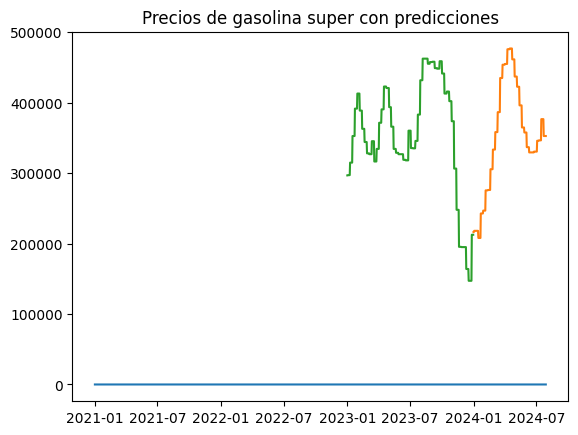

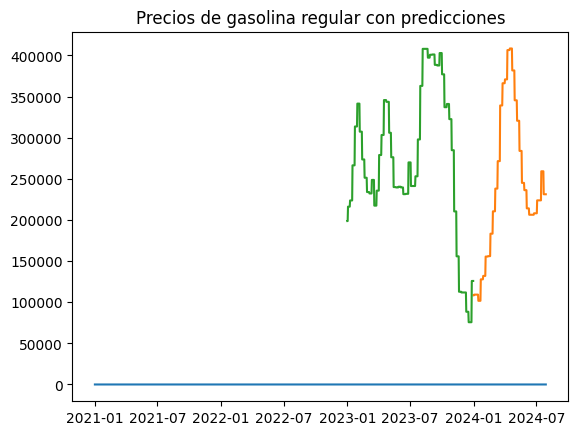

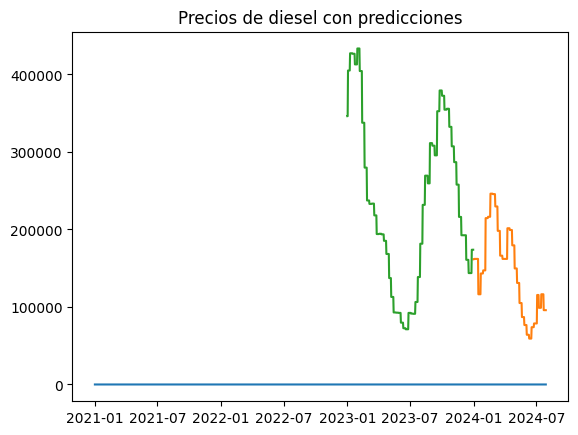

In [87]:
# Predicciones con precios

# Dataframes de predicciones
df_predict_precios_test_super = predictions_df(predict_precios_test['gasolina_super'], index_test_precios_super)
df_predict_precios_validation_super = predictions_df(predict_precios_validation['gasolina_super'], index_precios_validation_super)

plt.plot(serie_gasolina_super_precios_)
plt.plot(df_predict_precios_test_super)
plt.plot(df_predict_precios_validation_super)
plt.title('Precios de gasolina super con predicciones')


plt.show()

# Dataframes de predicciones
df_predict_precios_test_regular = predictions_df(predict_precios_test['gasolina_regular'], index_test_precios_regular)
df_predict_precios_validation_regular = predictions_df(predict_precios_validation['gasolina_regular'], index_precios_validation_regular)

plt.plot(serie_gasolina_regular_precios_)
plt.plot(df_predict_precios_test_regular)
plt.plot(df_predict_precios_validation_regular)
plt.title('Precios de gasolina regular con predicciones')


plt.show()

# Dataframes de predicciones
df_predict_precios_test_diesel = predictions_df(predict_precios_test['diesel'], index_test_precios_diesel)
df_predict_precios_validation_diesel = predictions_df(predict_precios_validation['diesel'], index_precios_validation_diesel)

plt.plot(serie_diesel_precios_)
plt.plot(df_predict_precios_test_diesel)
plt.plot(df_predict_precios_validation_diesel)
plt.title('Precios de diesel con predicciones')

plt.show()

Guardar los modelos. 

In [83]:
# save models of consumo
for key, model in consumo_models.items():
    model.save(f'consumo_model_{key}.h5')

# save models of importacion
for key, model in importacion_models.items():
    model.save(f'importacion_model_{key}.h5')

# save models of precios
for key, model in precios_models.items():
    model.save(f'precios_model_{key}.h5')

